### Load data and import necessary library

In [1]:
#Import necessary library
import pickle as pkl
from itertools import cycle
from sklearn.preprocessing import label_binarize
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style; style.use('fivethirtyeight')
from lightgbm import LGBMClassifier
from scipy.stats import zscore, norm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import data
task1 = pd.read_csv('./converted_data/converted_data.csv')
task2 = pd.read_csv('./converted_data/df_labels_balanced_converted.csv')

In [3]:
task1.head()

,iscancerous,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p2177,p2178,p2179,p2180,p2181,p2182,p2183,p2184,p2185,p2186
0,0,164,124,180,146,108,169,172,134,199,...,222,163,115,188,160,113,185,168,122,191
1,0,241,236,240,242,234,239,240,229,237,...,158,151,107,179,138,91,175,101,54,142
2,0,250,240,252,254,244,255,239,228,246,...,230,243,216,237,239,209,231,246,213,238
3,0,255,237,255,243,224,242,238,222,233,...,187,202,118,163,183,97,147,200,114,167
4,0,222,198,219,230,204,227,218,186,215,...,245,244,212,229,241,204,226,235,195,221


## Evaluation Metrics

In [4]:
def plot_multiclass_roc(clf, X_test, y_test):
    figsize=(17, 6)
    y_score = clf.predict_proba(X_test)
    n_classes = len(np.unique(y_test))


    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()


In [5]:
from sklearn.metrics import RocCurveDisplay
# Use this function to train and evaluate the model. If the model is a neural network, 
# change model_type to 'tf' and specified the trainning epochs
def train_and_plot(model, X_train , y_train, X_test, y_test, model_type = 'sk', epochs = 0):

    if model_type == 'sk' :
        model.fit(X_train, y_train)
        print('Model accuracy for train set: {0:.3f}'.format(model.score(X_train, y_train)))
        print('Model accuracy for test set: {0:.3f}'.format(model.score(X_test, y_test)))
        
        # fpr, tpr, thresholds = macro_roc(y_test, model.predict(X_test), n_classes = len(y_train.value_counts()))
        # roc_curve(y_test, model.predict_proba(X_test)[:,1])
    elif model_type == 'tf' :
        model.fit(X_train, y_train, epochs = epochs, verbose = 2)
        print('Model accuracy for train set: {0:.3f}'.format(model.evaluate(X_train, y_train, verbose=0)[1]))
        print('Model accuracy for test set: {0:.3f}'.format(model.evaluate(X_test, y_test, verbose=0)[1]))
        fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
    
    y_pred = model.predict(X_test)

    # Classification Report
    print('\n{}'.format(classification_report(y_test, y_pred)))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n', cm)
    plot_confusion_matrix(model, X_test, y_test)
    plt.title('Confusion Matrix')

    # Accuracy Score
    auc = accuracy_score(y_test, y_pred)
    print('\nAccuracy Score: ', auc.round(3))
    
    plot_multiclass_roc(model, X_test, y_test)
    
    
    return model

## Traditional Machine learning model

## Task 1

In [6]:
def set_gen(input_df, key = 'iscancerous') :
    X = input_df.drop(key, axis = 1)
    y = input_df[key]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42, shuffle = True, stratify = y)
    return X_train, X_test, y_train, y_test

In [7]:
X_train_1, X_test_1, y_train_1, y_test_1 = set_gen(task1)

In [8]:
print(X_train_1.shape)
print(y_train_1.shape)
print(X_test_1.shape)
print(y_test_1.shape)

(18270, 2187)
(18270,)
(7830, 2187)
(7830,)


[LightGBM] [Warning] Unknown parameter: use_label_encoder
Model accuracy for train set: 0.979
Model accuracy for test set: 0.912

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3915
           1       0.90      0.93      0.91      3915

    accuracy                           0.91      7830
   macro avg       0.91      0.91      0.91      7830
weighted avg       0.91      0.91      0.91      7830


Confusion Matrix:
 [[3511  404]
 [ 288 3627]]

Accuracy Score:  0.912


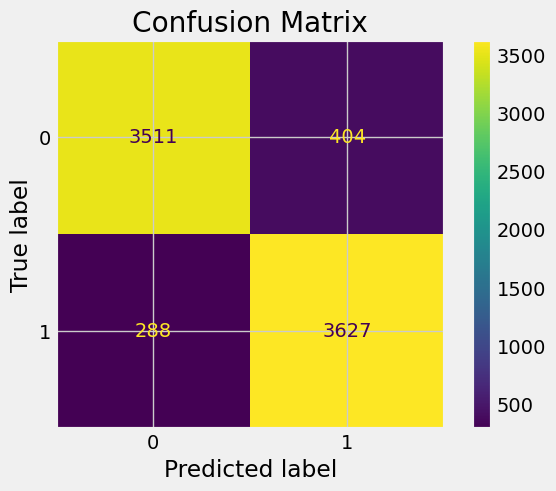

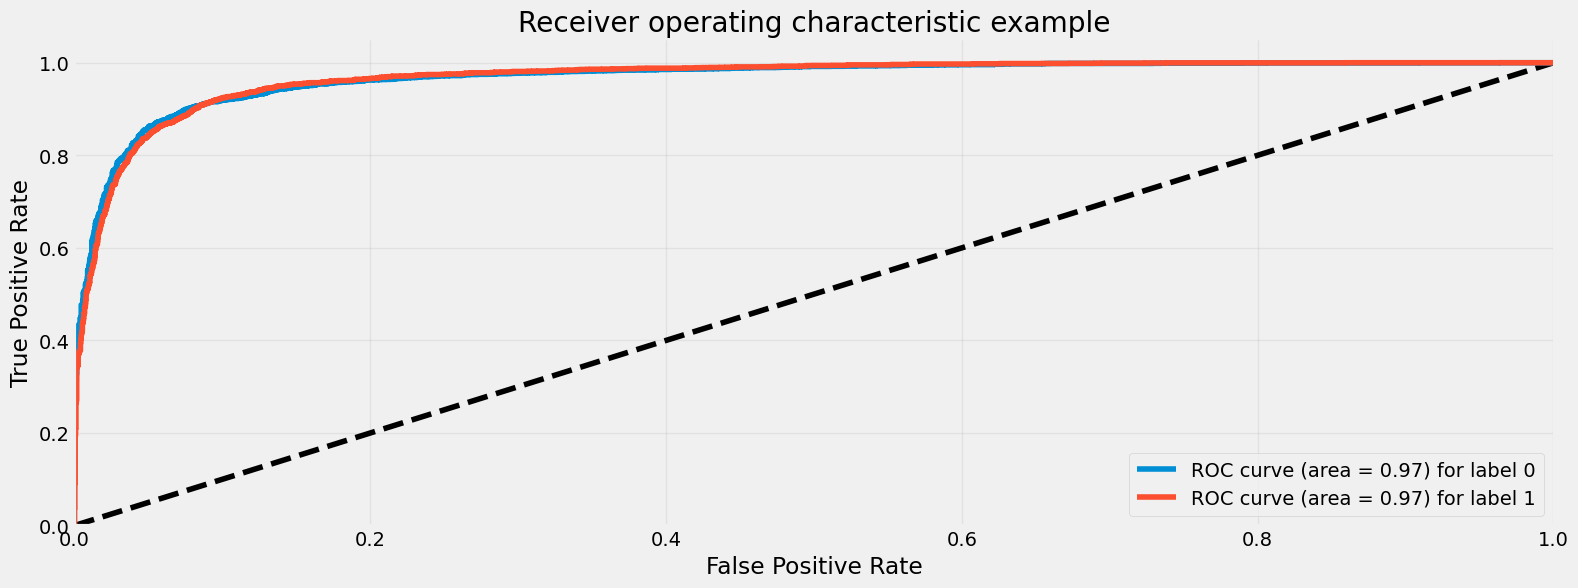

In [9]:
lgbm_clf = LGBMClassifier(random_state=42, use_label_encoder=False, n_jobs=-1)
lgbm_vanilla = train_and_plot(lgbm_clf, X_train_1, y_train_1, X_test_1, y_test_1)

In [10]:
# save model
pkl.dump(lgbm_vanilla, open('./model_result/lgbm_standard.pkl', "wb"))

### LightGBM Hyperparameter tunning

In [11]:
!pip3 install optuna
! pip install optuna-dashboard
## Run this command in a seperate terminal- min trail is 100
# optuna-dashboard sqlite:///db.sqlite3

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
import optuna


def objective(trial):
    
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    
    # -- Instantiate dimensionality reduction
     # (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, 40) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'
    
    pipeline = Pipeline([
        ("scaler", scaler),
        ("dim_red", dimen_red_algorithm),
        #Can change if gpu support is implementted
        ("lgbm", LGBMClassifier(n_jobs=-1))
    ])
    
        
    """Define the objective function"""
    # params = {
    #     'lgbm__max_depth': trial.suggest_int('max_depth', 1, 9),
    #     'lgbm__learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
    #     'lgbm__n_estimators': trial.suggest_int('n_estimators', 50, 500),
    #     'lgbm__min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    #     'lgbm__gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
    #     'lgbm__subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
    #     'lgbm__colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
    #     'lgbm__reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
    #     'lgbm__reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    #     'lgbm__eval_metric': 'mlogloss'
    # }

    params = {
        "lgbm__metric": "mlogloss",
        "lgbm__verbosity": -1,
        "lgbm__boosting_type": "gbdt",
        "lgbm__lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lgbm__lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "lgbm__num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "lgbm__feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "lgbm__bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "lgbm__bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "lgbm__min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }


    # Fit the model
    model = pipeline.set_params(**params)
    model.fit(X_train_1, y_train_1)

    # Make predictions
    y_pred = model.predict(X_test_1)

    # Evaluate predictions
    accuracy = accuracy_score(y_test_1, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize',
                            storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
                            study_name="lgbm_100_2")

[I 2023-01-15 20:45:27,012] A new study created in RDB with name: lgbm_100_2


In [25]:
study.optimize(objective, n_trials=100)

[LightGBM] [Warning] feature_fraction is set=0.923245222414509, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.923245222414509
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.43071622190244835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43071622190244835
[LightGBM] [Warning] lambda_l2 is set=1.4214824891804918e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4214824891804918e-07
[LightGBM] [Warning] lambda_l1 is set=2.8004281171939757e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8004281171939757e-05


[I 2023-01-15 20:45:34,790] Trial 0 finished with value: 0.8862068965517241 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 2.8004281171939757e-05, 'lambda_l2': 1.4214824891804918e-07, 'num_leaves': 10, 'feature_fraction': 0.923245222414509, 'bagging_fraction': 0.43071622190244835, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 0 with value: 0.8862068965517241.


[LightGBM] [Warning] feature_fraction is set=0.8871048106542617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8871048106542617
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8084533619052932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8084533619052932
[LightGBM] [Warning] lambda_l2 is set=1.2718898739580265e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2718898739580265e-06
[LightGBM] [Warning] lambda_l1 is set=5.993906154006017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.993906154006017


[I 2023-01-15 20:45:44,102] Trial 1 finished with value: 0.8832694763729246 and parameters: {'scalers': 'robust', 'dim_red': 'PCA', 'pca_n_components': 15, 'lambda_l1': 5.993906154006017, 'lambda_l2': 1.2718898739580265e-06, 'num_leaves': 105, 'feature_fraction': 0.8871048106542617, 'bagging_fraction': 0.8084533619052932, 'bagging_freq': 7, 'min_child_samples': 87}. Best is trial 0 with value: 0.8862068965517241.


[LightGBM] [Warning] feature_fraction is set=0.8269410780802836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8269410780802836
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7665221849433561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7665221849433561
[LightGBM] [Warning] lambda_l2 is set=0.5810084131466965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5810084131466965
[LightGBM] [Warning] lambda_l1 is set=0.006417285502819344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006417285502819344


[I 2023-01-15 20:45:55,943] Trial 2 finished with value: 0.9126436781609195 and parameters: {'scalers': 'robust', 'dim_red': 'PCA', 'pca_n_components': 35, 'lambda_l1': 0.006417285502819344, 'lambda_l2': 0.5810084131466965, 'num_leaves': 113, 'feature_fraction': 0.8269410780802836, 'bagging_fraction': 0.7665221849433561, 'bagging_freq': 5, 'min_child_samples': 64}. Best is trial 2 with value: 0.9126436781609195.


[LightGBM] [Warning] feature_fraction is set=0.5262347282971986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5262347282971986
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7944075645337849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7944075645337849
[LightGBM] [Warning] lambda_l2 is set=0.0005464619932870051, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005464619932870051
[LightGBM] [Warning] lambda_l1 is set=0.06818504546986755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06818504546986755


[I 2023-01-15 20:46:29,678] Trial 3 finished with value: 0.9204342273307791 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.06818504546986755, 'lambda_l2': 0.0005464619932870051, 'num_leaves': 167, 'feature_fraction': 0.5262347282971986, 'bagging_fraction': 0.7944075645337849, 'bagging_freq': 4, 'min_child_samples': 41}. Best is trial 3 with value: 0.9204342273307791.


[LightGBM] [Warning] feature_fraction is set=0.6943525929319772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6943525929319772
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8545243911965072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8545243911965072
[LightGBM] [Warning] lambda_l2 is set=7.815206747718313e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.815206747718313e-07
[LightGBM] [Warning] lambda_l1 is set=1.7028242654914798e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7028242654914798e-05


[I 2023-01-15 20:47:23,585] Trial 4 finished with value: 0.9197956577266923 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.7028242654914798e-05, 'lambda_l2': 7.815206747718313e-07, 'num_leaves': 242, 'feature_fraction': 0.6943525929319772, 'bagging_fraction': 0.8545243911965072, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 3 with value: 0.9204342273307791.


[LightGBM] [Warning] feature_fraction is set=0.5335414263149876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5335414263149876
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6186049122732471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6186049122732471
[LightGBM] [Warning] lambda_l2 is set=0.06684547830888285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06684547830888285
[LightGBM] [Warning] lambda_l1 is set=7.353589449064196e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.353589449064196e-08


[I 2023-01-15 20:47:31,716] Trial 5 finished with value: 0.890676883780332 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 17, 'lambda_l1': 7.353589449064196e-08, 'lambda_l2': 0.06684547830888285, 'num_leaves': 102, 'feature_fraction': 0.5335414263149876, 'bagging_fraction': 0.6186049122732471, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 3 with value: 0.9204342273307791.


[LightGBM] [Warning] feature_fraction is set=0.5640497903670945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5640497903670945
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5249608525197322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5249608525197322
[LightGBM] [Warning] lambda_l2 is set=1.5581833526713595e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5581833526713595e-05
[LightGBM] [Warning] lambda_l1 is set=0.013084450852989045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013084450852989045


[I 2023-01-15 20:48:04,601] Trial 6 finished with value: 0.9187739463601533 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 0.013084450852989045, 'lambda_l2': 1.5581833526713595e-05, 'num_leaves': 182, 'feature_fraction': 0.5640497903670945, 'bagging_fraction': 0.5249608525197322, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 3 with value: 0.9204342273307791.


[LightGBM] [Warning] feature_fraction is set=0.7124271345952827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7124271345952827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8289938995120346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8289938995120346
[LightGBM] [Warning] lambda_l2 is set=0.00020029797875615007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020029797875615007
[LightGBM] [Warning] lambda_l1 is set=0.00971402119130235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00971402119130235


[I 2023-01-15 20:48:44,418] Trial 7 finished with value: 0.9077905491698595 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 0.00971402119130235, 'lambda_l2': 0.00020029797875615007, 'num_leaves': 25, 'feature_fraction': 0.7124271345952827, 'bagging_fraction': 0.8289938995120346, 'bagging_freq': 1, 'min_child_samples': 29}. Best is trial 3 with value: 0.9204342273307791.


[LightGBM] [Warning] feature_fraction is set=0.8999132929488796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999132929488796
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7879175457240161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7879175457240161
[LightGBM] [Warning] lambda_l2 is set=0.0057664527053034025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0057664527053034025
[LightGBM] [Warning] lambda_l1 is set=5.205053193930097e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.205053193930097e-06


[I 2023-01-15 20:51:22,784] Trial 8 finished with value: 0.9189016602809706 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 5.205053193930097e-06, 'lambda_l2': 0.0057664527053034025, 'num_leaves': 209, 'feature_fraction': 0.8999132929488796, 'bagging_fraction': 0.7879175457240161, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 3 with value: 0.9204342273307791.


[LightGBM] [Warning] feature_fraction is set=0.6983859136163607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6983859136163607
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.741239927345835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.741239927345835
[LightGBM] [Warning] lambda_l2 is set=0.00041476031167129453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00041476031167129453
[LightGBM] [Warning] lambda_l1 is set=2.4485980290300474e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4485980290300474e-08


[I 2023-01-15 20:52:25,357] Trial 9 finished with value: 0.9195402298850575 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 2.4485980290300474e-08, 'lambda_l2': 0.00041476031167129453, 'num_leaves': 186, 'feature_fraction': 0.6983859136163607, 'bagging_fraction': 0.741239927345835, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 3 with value: 0.9204342273307791.


[LightGBM] [Warning] feature_fraction is set=0.4664216260955645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4664216260955645
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9735271112140976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9735271112140976
[LightGBM] [Warning] lambda_l2 is set=5.692683694262682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.692683694262682
[LightGBM] [Warning] lambda_l1 is set=1.1033908979571134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1033908979571134


[I 2023-01-15 20:52:47,097] Trial 10 finished with value: 0.9196679438058748 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.1033908979571134, 'lambda_l2': 5.692683694262682, 'num_leaves': 154, 'feature_fraction': 0.4664216260955645, 'bagging_fraction': 0.9735271112140976, 'bagging_freq': 3, 'min_child_samples': 43}. Best is trial 3 with value: 0.9204342273307791.


[LightGBM] [Warning] feature_fraction is set=0.6583579794205688, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6583579794205688
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9437717235325457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9437717235325457
[LightGBM] [Warning] lambda_l2 is set=1.1071857921062827e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1071857921062827e-08
[LightGBM] [Warning] lambda_l1 is set=0.000134507761558518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000134507761558518


[I 2023-01-15 20:53:40,082] Trial 11 finished with value: 0.919029374201788 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.000134507761558518, 'lambda_l2': 1.1071857921062827e-08, 'num_leaves': 248, 'feature_fraction': 0.6583579794205688, 'bagging_fraction': 0.9437717235325457, 'bagging_freq': 4, 'min_child_samples': 50}. Best is trial 3 with value: 0.9204342273307791.


[LightGBM] [Warning] feature_fraction is set=0.4044997008221709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4044997008221709
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8928507906715762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8928507906715762
[LightGBM] [Warning] lambda_l2 is set=1.167617992882162e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.167617992882162e-05
[LightGBM] [Warning] lambda_l1 is set=1.5481338016700701e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5481338016700701e-06


[I 2023-01-15 20:54:10,767] Trial 12 finished with value: 0.9213282247765007 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.5481338016700701e-06, 'lambda_l2': 1.167617992882162e-05, 'num_leaves': 256, 'feature_fraction': 0.4044997008221709, 'bagging_fraction': 0.8928507906715762, 'bagging_freq': 5, 'min_child_samples': 69}. Best is trial 12 with value: 0.9213282247765007.


[LightGBM] [Warning] feature_fraction is set=0.40749457349847623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40749457349847623
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6408312977230429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6408312977230429
[LightGBM] [Warning] lambda_l2 is set=9.37728673706993e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.37728673706993e-05
[LightGBM] [Warning] lambda_l1 is set=7.139248591841196e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.139248591841196e-07


[I 2023-01-15 20:54:23,538] Trial 13 finished with value: 0.9177522349936144 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 7.139248591841196e-07, 'lambda_l2': 9.37728673706993e-05, 'num_leaves': 55, 'feature_fraction': 0.40749457349847623, 'bagging_fraction': 0.6408312977230429, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 12 with value: 0.9213282247765007.


[LightGBM] [Warning] feature_fraction is set=0.40823517419347255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40823517419347255
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9021146218316226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9021146218316226
[LightGBM] [Warning] lambda_l2 is set=0.004996115560531625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004996115560531625
[LightGBM] [Warning] lambda_l1 is set=0.12023968529862868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12023968529862868


[I 2023-01-15 20:54:46,627] Trial 14 finished with value: 0.9218390804597701 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.12023968529862868, 'lambda_l2': 0.004996115560531625, 'num_leaves': 215, 'feature_fraction': 0.40823517419347255, 'bagging_fraction': 0.9021146218316226, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 14 with value: 0.9218390804597701.


[LightGBM] [Warning] feature_fraction is set=0.4095467600123573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4095467600123573
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9062210839184046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9062210839184046
[LightGBM] [Warning] lambda_l2 is set=0.010162553414596959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010162553414596959
[LightGBM] [Warning] lambda_l1 is set=0.0004464641086690405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004464641086690405


[I 2023-01-15 20:54:54,933] Trial 15 finished with value: 0.7835249042145593 and parameters: {'scalers': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 4, 'lambda_l1': 0.0004464641086690405, 'lambda_l2': 0.010162553414596959, 'num_leaves': 217, 'feature_fraction': 0.4095467600123573, 'bagging_fraction': 0.9062210839184046, 'bagging_freq': 7, 'min_child_samples': 73}. Best is trial 14 with value: 0.9218390804597701.


[LightGBM] [Warning] feature_fraction is set=0.4832394852761873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4832394852761873
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.89700000640126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.89700000640126
[LightGBM] [Warning] lambda_l2 is set=1.1794030740675595e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1794030740675595e-05
[LightGBM] [Warning] lambda_l1 is set=1.1446203791521368e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1446203791521368e-06


[I 2023-01-15 20:55:24,275] Trial 16 finished with value: 0.9200510855683269 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.1446203791521368e-06, 'lambda_l2': 1.1794030740675595e-05, 'num_leaves': 252, 'feature_fraction': 0.4832394852761873, 'bagging_fraction': 0.89700000640126, 'bagging_freq': 5, 'min_child_samples': 80}. Best is trial 14 with value: 0.9218390804597701.


[LightGBM] [Warning] feature_fraction is set=0.6191233691345246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6191233691345246
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9907738532722965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9907738532722965
[LightGBM] [Warning] lambda_l2 is set=0.0026148251132928923, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026148251132928923
[LightGBM] [Warning] lambda_l1 is set=0.26987458638640105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26987458638640105


[I 2023-01-15 20:55:57,929] Trial 17 finished with value: 0.9157088122605364 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.26987458638640105, 'lambda_l2': 0.0026148251132928923, 'num_leaves': 217, 'feature_fraction': 0.6191233691345246, 'bagging_fraction': 0.9907738532722965, 'bagging_freq': 6, 'min_child_samples': 65}. Best is trial 14 with value: 0.9218390804597701.


[LightGBM] [Warning] feature_fraction is set=0.7720124677003797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7720124677003797
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6943933649632796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6943933649632796
[LightGBM] [Warning] lambda_l2 is set=0.11247632411382306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11247632411382306
[LightGBM] [Warning] lambda_l1 is set=0.001524165473099841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001524165473099841


[I 2023-01-15 20:56:09,569] Trial 18 finished with value: 0.9057471264367816 and parameters: {'scalers': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 40, 'lambda_l1': 0.001524165473099841, 'lambda_l2': 0.11247632411382306, 'num_leaves': 148, 'feature_fraction': 0.7720124677003797, 'bagging_fraction': 0.6943933649632796, 'bagging_freq': 2, 'min_child_samples': 93}. Best is trial 14 with value: 0.9218390804597701.


[LightGBM] [Warning] feature_fraction is set=0.6004956447993375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6004956447993375
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8899298749701539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8899298749701539
[LightGBM] [Warning] lambda_l2 is set=1.76149214979037e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.76149214979037e-05
[LightGBM] [Warning] lambda_l1 is set=1.3365507366045765e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3365507366045765e-07


[I 2023-01-15 20:56:50,992] Trial 19 finished with value: 0.9213282247765007 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.3365507366045765e-07, 'lambda_l2': 1.76149214979037e-05, 'num_leaves': 199, 'feature_fraction': 0.6004956447993375, 'bagging_fraction': 0.8899298749701539, 'bagging_freq': 5, 'min_child_samples': 58}. Best is trial 14 with value: 0.9218390804597701.


[LightGBM] [Warning] feature_fraction is set=0.9861550572392216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9861550572392216
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.702193560999626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.702193560999626
[LightGBM] [Warning] lambda_l2 is set=0.027879548645449635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.027879548645449635
[LightGBM] [Warning] lambda_l1 is set=1.1085133742773492e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1085133742773492e-08


[I 2023-01-15 20:57:19,478] Trial 20 finished with value: 0.9178799489144317 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 1.1085133742773492e-08, 'lambda_l2': 0.027879548645449635, 'num_leaves': 75, 'feature_fraction': 0.9861550572392216, 'bagging_fraction': 0.702193560999626, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 14 with value: 0.9218390804597701.


[LightGBM] [Warning] feature_fraction is set=0.45470829139411956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45470829139411956
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8783694441001673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8783694441001673
[LightGBM] [Warning] lambda_l2 is set=1.3780659786884607e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3780659786884607e-05
[LightGBM] [Warning] lambda_l1 is set=5.109452814052019e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.109452814052019e-07


[I 2023-01-15 20:57:55,518] Trial 21 finished with value: 0.9217113665389527 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 5.109452814052019e-07, 'lambda_l2': 1.3780659786884607e-05, 'num_leaves': 201, 'feature_fraction': 0.45470829139411956, 'bagging_fraction': 0.8783694441001673, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 14 with value: 0.9218390804597701.


[LightGBM] [Warning] feature_fraction is set=0.5816499405911423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5816499405911423
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8705080567422835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8705080567422835
[LightGBM] [Warning] lambda_l2 is set=1.2257456317807677e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2257456317807677e-06
[LightGBM] [Warning] lambda_l1 is set=1.813533924696711e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.813533924696711e-07


[I 2023-01-15 20:58:26,429] Trial 22 finished with value: 0.9237547892720307 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.813533924696711e-07, 'lambda_l2': 1.2257456317807677e-06, 'num_leaves': 201, 'feature_fraction': 0.5816499405911423, 'bagging_fraction': 0.8705080567422835, 'bagging_freq': 4, 'min_child_samples': 85}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4844429987838868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4844429987838868
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8459001071832074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8459001071832074
[LightGBM] [Warning] lambda_l2 is set=7.119040811436556e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.119040811436556e-07
[LightGBM] [Warning] lambda_l1 is set=1.8075787315170418e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8075787315170418e-07


[I 2023-01-15 20:58:53,694] Trial 23 finished with value: 0.918007662835249 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.8075787315170418e-07, 'lambda_l2': 7.119040811436556e-07, 'num_leaves': 134, 'feature_fraction': 0.4844429987838868, 'bagging_fraction': 0.8459001071832074, 'bagging_freq': 4, 'min_child_samples': 82}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4578107401592099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4578107401592099
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9424536839185425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9424536839185425
[LightGBM] [Warning] lambda_l2 is set=5.374602989580227e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.374602989580227e-08
[LightGBM] [Warning] lambda_l1 is set=0.0001243042863629217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001243042863629217


[I 2023-01-15 21:06:41,314] Trial 24 finished with value: 0.9196679438058748 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.0001243042863629217, 'lambda_l2': 5.374602989580227e-08, 'num_leaves': 228, 'feature_fraction': 0.4578107401592099, 'bagging_fraction': 0.9424536839185425, 'bagging_freq': 3, 'min_child_samples': 84}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.540150022496982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.540150022496982
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9337743657350954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9337743657350954
[LightGBM] [Warning] lambda_l2 is set=3.540955975605931e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.540955975605931e-06
[LightGBM] [Warning] lambda_l1 is set=1.060259635130054e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.060259635130054e-05


[I 2023-01-15 21:07:03,717] Trial 25 finished with value: 0.9217113665389527 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.060259635130054e-05, 'lambda_l2': 3.540955975605931e-06, 'num_leaves': 181, 'feature_fraction': 0.540150022496982, 'bagging_fraction': 0.9337743657350954, 'bagging_freq': 2, 'min_child_samples': 90}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5665935382967369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5665935382967369
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9425190727606589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9425190727606589
[LightGBM] [Warning] lambda_l2 is set=2.3983295923376694e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3983295923376694e-06
[LightGBM] [Warning] lambda_l1 is set=7.277985076154621e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.277985076154621e-06


[I 2023-01-15 21:07:10,202] Trial 26 finished with value: 0.910727969348659 and parameters: {'scalers': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 29, 'lambda_l1': 7.277985076154621e-06, 'lambda_l2': 2.3983295923376694e-06, 'num_leaves': 172, 'feature_fraction': 0.5665935382967369, 'bagging_fraction': 0.9425190727606589, 'bagging_freq': 2, 'min_child_samples': 91}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4511452836700365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4511452836700365
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8568018667727707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8568018667727707
[LightGBM] [Warning] lambda_l2 is set=6.11795968530421e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.11795968530421e-05
[LightGBM] [Warning] lambda_l1 is set=0.0010627967343560466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010627967343560466


[I 2023-01-15 21:07:28,394] Trial 27 finished with value: 0.9223499361430396 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.0010627967343560466, 'lambda_l2': 6.11795968530421e-05, 'num_leaves': 200, 'feature_fraction': 0.4511452836700365, 'bagging_fraction': 0.8568018667727707, 'bagging_freq': 4, 'min_child_samples': 72}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5029290504969871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5029290504969871
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.743331586613024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743331586613024
[LightGBM] [Warning] lambda_l2 is set=0.001272111224312603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001272111224312603
[LightGBM] [Warning] lambda_l1 is set=0.07342914575008187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07342914575008187


[I 2023-01-15 21:07:42,033] Trial 28 finished with value: 0.9209450830140485 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.07342914575008187, 'lambda_l2': 0.001272111224312603, 'num_leaves': 232, 'feature_fraction': 0.5029290504969871, 'bagging_fraction': 0.743331586613024, 'bagging_freq': 4, 'min_child_samples': 100}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.6285583281687342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6285583281687342
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.4834729577816297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4834729577816297
[LightGBM] [Warning] lambda_l2 is set=0.00010768378926915605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010768378926915605
[LightGBM] [Warning] lambda_l1 is set=0.0008774693558029708, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008774693558029708


[I 2023-01-15 21:07:58,964] Trial 29 finished with value: 0.9174968071519796 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.0008774693558029708, 'lambda_l2': 0.00010768378926915605, 'num_leaves': 156, 'feature_fraction': 0.6285583281687342, 'bagging_fraction': 0.4834729577816297, 'bagging_freq': 3, 'min_child_samples': 77}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.45073782887791924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45073782887791924
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.40517805502839627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40517805502839627
[LightGBM] [Warning] lambda_l2 is set=2.811576493297359e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.811576493297359e-07
[LightGBM] [Warning] lambda_l1 is set=0.00319627762659352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00319627762659352


[I 2023-01-15 21:08:10,379] Trial 30 finished with value: 0.916602809706258 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.00319627762659352, 'lambda_l2': 2.811576493297359e-07, 'num_leaves': 195, 'feature_fraction': 0.45073782887791924, 'bagging_fraction': 0.40517805502839627, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4336112102790443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4336112102790443
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8573302741186685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8573302741186685
[LightGBM] [Warning] lambda_l2 is set=3.401826341633912e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.401826341633912e-05
[LightGBM] [Warning] lambda_l1 is set=0.00012371242827048778, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012371242827048778


[I 2023-01-15 21:08:28,891] Trial 31 finished with value: 0.9209450830140485 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.00012371242827048778, 'lambda_l2': 3.401826341633912e-05, 'num_leaves': 204, 'feature_fraction': 0.4336112102790443, 'bagging_fraction': 0.8573302741186685, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5643754860920224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5643754860920224
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9332956071147073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9332956071147073
[LightGBM] [Warning] lambda_l2 is set=3.292556125451555e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.292556125451555e-06
[LightGBM] [Warning] lambda_l1 is set=8.910223858484766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.910223858484766


[I 2023-01-15 21:08:37,936] Trial 32 finished with value: 0.909323116219668 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 8.910223858484766, 'lambda_l2': 3.292556125451555e-06, 'num_leaves': 227, 'feature_fraction': 0.5643754860920224, 'bagging_fraction': 0.9332956071147073, 'bagging_freq': 2, 'min_child_samples': 88}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5134185081184308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5134185081184308
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9977160282311052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9977160282311052
[LightGBM] [Warning] lambda_l2 is set=1.753986078902373e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.753986078902373e-07
[LightGBM] [Warning] lambda_l1 is set=2.799408044701504e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.799408044701504e-05


[I 2023-01-15 21:09:00,674] Trial 33 finished with value: 0.9167305236270753 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 2.799408044701504e-05, 'lambda_l2': 1.753986078902373e-07, 'num_leaves': 183, 'feature_fraction': 0.5134185081184308, 'bagging_fraction': 0.9977160282311052, 'bagging_freq': 2, 'min_child_samples': 85}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4398432075686369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4398432075686369
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8079688101424418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8079688101424418
[LightGBM] [Warning] lambda_l2 is set=3.972734248356868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.972734248356868e-05
[LightGBM] [Warning] lambda_l1 is set=0.03775865609919296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03775865609919296


[I 2023-01-15 21:09:04,736] Trial 34 finished with value: 0.6818646232439336 and parameters: {'scalers': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 2, 'lambda_l1': 0.03775865609919296, 'lambda_l2': 3.972734248356868e-05, 'num_leaves': 130, 'feature_fraction': 0.4398432075686369, 'bagging_fraction': 0.8079688101424418, 'bagging_freq': 5, 'min_child_samples': 67}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5402733306334795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5402733306334795
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9645385681203953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9645385681203953
[LightGBM] [Warning] lambda_l2 is set=3.6050287388478983e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6050287388478983e-06
[LightGBM] [Warning] lambda_l1 is set=0.9266063160025148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9266063160025148


[I 2023-01-15 21:09:24,982] Trial 35 finished with value: 0.9194125159642401 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 0.9266063160025148, 'lambda_l2': 3.6050287388478983e-06, 'num_leaves': 171, 'feature_fraction': 0.5402733306334795, 'bagging_fraction': 0.9645385681203953, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4945087895876281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4945087895876281
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8717545732010578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8717545732010578
[LightGBM] [Warning] lambda_l2 is set=5.1024177208536184e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1024177208536184e-08
[LightGBM] [Warning] lambda_l1 is set=2.587039126972244e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.587039126972244e-06


[I 2023-01-15 21:09:47,179] Trial 36 finished with value: 0.9215836526181354 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 2.587039126972244e-06, 'lambda_l2': 5.1024177208536184e-08, 'num_leaves': 235, 'feature_fraction': 0.4945087895876281, 'bagging_fraction': 0.8717545732010578, 'bagging_freq': 4, 'min_child_samples': 74}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.592435908844831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.592435908844831
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9158795917638676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9158795917638676
[LightGBM] [Warning] lambda_l2 is set=0.0006695637414164302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006695637414164302
[LightGBM] [Warning] lambda_l1 is set=1.482113631419843e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.482113631419843e-05


[I 2023-01-15 21:09:52,594] Trial 37 finished with value: 0.9057471264367816 and parameters: {'scalers': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 25, 'lambda_l1': 1.482113631419843e-05, 'lambda_l2': 0.0006695637414164302, 'num_leaves': 110, 'feature_fraction': 0.592435908844831, 'bagging_fraction': 0.9158795917638676, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5381262442813359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5381262442813359
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8281498135245275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8281498135245275
[LightGBM] [Warning] lambda_l2 is set=3.741322905676107e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.741322905676107e-07
[LightGBM] [Warning] lambda_l1 is set=4.459087893285084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.459087893285084e-05


[I 2023-01-15 21:10:19,250] Trial 38 finished with value: 0.9204342273307791 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 4.459087893285084e-05, 'lambda_l2': 3.741322905676107e-07, 'num_leaves': 216, 'feature_fraction': 0.5381262442813359, 'bagging_fraction': 0.8281498135245275, 'bagging_freq': 1, 'min_child_samples': 79}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.6640118966501982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6640118966501982
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7836623211962945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7836623211962945
[LightGBM] [Warning] lambda_l2 is set=0.32021096456082415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.32021096456082415
[LightGBM] [Warning] lambda_l1 is set=1.5101777486440855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5101777486440855


[I 2023-01-15 21:10:30,831] Trial 39 finished with value: 0.9163473818646233 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.5101777486440855, 'lambda_l2': 0.32021096456082415, 'num_leaves': 188, 'feature_fraction': 0.6640118966501982, 'bagging_fraction': 0.7836623211962945, 'bagging_freq': 3, 'min_child_samples': 98}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.8087384701053533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8087384701053533
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.8236786439244655, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8236786439244655
[LightGBM] [Warning] lambda_l2 is set=0.00016563575472768678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016563575472768678
[LightGBM] [Warning] lambda_l1 is set=2.9187103925081724e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9187103925081724e-07


[I 2023-01-15 21:10:52,591] Trial 40 finished with value: 0.919029374201788 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 2.9187103925081724e-07, 'lambda_l2': 0.00016563575472768678, 'num_leaves': 90, 'feature_fraction': 0.8087384701053533, 'bagging_fraction': 0.8236786439244655, 'bagging_freq': 6, 'min_child_samples': 52}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.43128079939326613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43128079939326613
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8457456329732992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8457456329732992
[LightGBM] [Warning] lambda_l2 is set=1.4875471396488475e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4875471396488475e-06
[LightGBM] [Warning] lambda_l1 is set=5.928658584364693e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.928658584364693e-07


[I 2023-01-15 21:11:16,399] Trial 41 finished with value: 0.922477650063857 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 5.928658584364693e-07, 'lambda_l2': 1.4875471396488475e-06, 'num_leaves': 201, 'feature_fraction': 0.43128079939326613, 'bagging_fraction': 0.8457456329732992, 'bagging_freq': 5, 'min_child_samples': 69}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4309218108087204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4309218108087204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8604138553304701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8604138553304701
[LightGBM] [Warning] lambda_l2 is set=1.3687976465320225e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3687976465320225e-06
[LightGBM] [Warning] lambda_l1 is set=5.655371535200584e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.655371535200584e-08


[I 2023-01-15 21:11:47,628] Trial 42 finished with value: 0.9191570881226053 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 5.655371535200584e-08, 'lambda_l2': 1.3687976465320225e-06, 'num_leaves': 180, 'feature_fraction': 0.4309218108087204, 'bagging_fraction': 0.8604138553304701, 'bagging_freq': 4, 'min_child_samples': 60}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.47112871501116993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47112871501116993
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7612629157516064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612629157516064
[LightGBM] [Warning] lambda_l2 is set=6.521425398954661e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.521425398954661e-06
[LightGBM] [Warning] lambda_l1 is set=4.0138746970969905e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0138746970969905e-07


[I 2023-01-15 21:12:21,517] Trial 43 finished with value: 0.9220945083014048 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 4.0138746970969905e-07, 'lambda_l2': 6.521425398954661e-06, 'num_leaves': 203, 'feature_fraction': 0.47112871501116993, 'bagging_fraction': 0.7612629157516064, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.40240111413661095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40240111413661095
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7504789134699428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7504789134699428
[LightGBM] [Warning] lambda_l2 is set=5.350050661507311e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.350050661507311e-05
[LightGBM] [Warning] lambda_l1 is set=7.526885537505781e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.526885537505781e-08


[I 2023-01-15 21:12:41,625] Trial 44 finished with value: 0.9201787994891443 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 7.526885537505781e-08, 'lambda_l2': 5.350050661507311e-05, 'num_leaves': 164, 'feature_fraction': 0.40240111413661095, 'bagging_fraction': 0.7504789134699428, 'bagging_freq': 5, 'min_child_samples': 76}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4806148986484368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4806148986484368
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7710514924185068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7710514924185068
[LightGBM] [Warning] lambda_l2 is set=8.785996026571982e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.785996026571982e-07
[LightGBM] [Warning] lambda_l1 is set=0.020013335106002825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020013335106002825


[I 2023-01-15 21:13:06,671] Trial 45 finished with value: 0.9213282247765007 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.020013335106002825, 'lambda_l2': 8.785996026571982e-07, 'num_leaves': 210, 'feature_fraction': 0.4806148986484368, 'bagging_fraction': 0.7710514924185068, 'bagging_freq': 6, 'min_child_samples': 65}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.749878647462147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.749878647462147
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7211624206979766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7211624206979766
[LightGBM] [Warning] lambda_l2 is set=6.718704005197507e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.718704005197507e-08
[LightGBM] [Warning] lambda_l1 is set=3.0722040566579564e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0722040566579564e-06


[I 2023-01-15 21:13:39,050] Trial 46 finished with value: 0.9215836526181354 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 3.0722040566579564e-06, 'lambda_l2': 6.718704005197507e-08, 'num_leaves': 244, 'feature_fraction': 0.749878647462147, 'bagging_fraction': 0.7211624206979766, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4243681012858236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4243681012858236
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6674730408665832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6674730408665832
[LightGBM] [Warning] lambda_l2 is set=0.009222372881860586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009222372881860586
[LightGBM] [Warning] lambda_l1 is set=2.3371252919348377e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3371252919348377e-08


[I 2023-01-15 21:13:49,774] Trial 47 finished with value: 0.8950191570881226 and parameters: {'scalers': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 12, 'lambda_l1': 2.3371252919348377e-08, 'lambda_l2': 0.009222372881860586, 'num_leaves': 195, 'feature_fraction': 0.4243681012858236, 'bagging_fraction': 0.6674730408665832, 'bagging_freq': 4, 'min_child_samples': 13}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5106827837232818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5106827837232818
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8066637546909391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8066637546909391
[LightGBM] [Warning] lambda_l2 is set=0.00029624012066967745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029624012066967745
[LightGBM] [Warning] lambda_l1 is set=0.004619063871187584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004619063871187584


[I 2023-01-15 21:14:19,072] Trial 48 finished with value: 0.9220945083014048 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.004619063871187584, 'lambda_l2': 0.00029624012066967745, 'num_leaves': 146, 'feature_fraction': 0.5106827837232818, 'bagging_fraction': 0.8066637546909391, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.513163175796925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.513163175796925
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.790462267922771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.790462267922771
[LightGBM] [Warning] lambda_l2 is set=0.0003878696502823646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003878696502823646
[LightGBM] [Warning] lambda_l1 is set=0.0022017245465536382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0022017245465536382


[I 2023-01-15 21:15:07,766] Trial 49 finished with value: 0.921455938697318 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 0.0022017245465536382, 'lambda_l2': 0.0003878696502823646, 'num_leaves': 148, 'feature_fraction': 0.513163175796925, 'bagging_fraction': 0.790462267922771, 'bagging_freq': 4, 'min_child_samples': 37}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5768211144821298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5768211144821298
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.8073857440762552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8073857440762552
[LightGBM] [Warning] lambda_l2 is set=6.972787463598239e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.972787463598239e-06
[LightGBM] [Warning] lambda_l1 is set=0.0002921399334249128, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002921399334249128


[I 2023-01-15 21:15:11,237] Trial 50 finished with value: 0.8597701149425288 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.0002921399334249128, 'lambda_l2': 6.972787463598239e-06, 'num_leaves': 3, 'feature_fraction': 0.5768211144821298, 'bagging_fraction': 0.8073857440762552, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4670323259533263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4670323259533263
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8445606069358125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8445606069358125
[LightGBM] [Warning] lambda_l2 is set=0.002011708269997473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002011708269997473
[LightGBM] [Warning] lambda_l1 is set=0.004725384778575593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004725384778575593


[I 2023-01-15 21:16:06,788] Trial 51 finished with value: 0.9231162196679438 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.004725384778575593, 'lambda_l2': 0.002011708269997473, 'num_leaves': 222, 'feature_fraction': 0.4670323259533263, 'bagging_fraction': 0.8445606069358125, 'bagging_freq': 5, 'min_child_samples': 43}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.47582682497824647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47582682497824647
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8290532320329752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8290532320329752
[LightGBM] [Warning] lambda_l2 is set=0.001291943564611756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001291943564611756
[LightGBM] [Warning] lambda_l1 is set=0.007822725769411148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007822725769411148


[I 2023-01-15 21:17:25,801] Trial 52 finished with value: 0.9201787994891443 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.007822725769411148, 'lambda_l2': 0.001291943564611756, 'num_leaves': 236, 'feature_fraction': 0.47582682497824647, 'bagging_fraction': 0.8290532320329752, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.520579832663669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.520579832663669
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.595494791318491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.595494791318491
[LightGBM] [Warning] lambda_l2 is set=8.449673503531675e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.449673503531675e-05
[LightGBM] [Warning] lambda_l1 is set=0.0009806625298665655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009806625298665655


[I 2023-01-15 21:18:02,734] Trial 53 finished with value: 0.921455938697318 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.0009806625298665655, 'lambda_l2': 8.449673503531675e-05, 'num_leaves': 220, 'feature_fraction': 0.520579832663669, 'bagging_fraction': 0.595494791318491, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4653322880224661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4653322880224661
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.843786727489483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.843786727489483
[LightGBM] [Warning] lambda_l2 is set=0.00020651936365006018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020651936365006018
[LightGBM] [Warning] lambda_l1 is set=0.020881734679808757, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020881734679808757


[I 2023-01-15 21:18:38,502] Trial 54 finished with value: 0.9189016602809706 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.020881734679808757, 'lambda_l2': 0.00020651936365006018, 'num_leaves': 205, 'feature_fraction': 0.4653322880224661, 'bagging_fraction': 0.843786727489483, 'bagging_freq': 5, 'min_child_samples': 43}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4958557067823889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4958557067823889
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7635212367382513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7635212367382513
[LightGBM] [Warning] lambda_l2 is set=7.37705997081356e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.37705997081356e-06
[LightGBM] [Warning] lambda_l1 is set=0.00036095634933157306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00036095634933157306


[I 2023-01-15 21:19:07,193] Trial 55 finished with value: 0.918007662835249 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.00036095634933157306, 'lambda_l2': 7.37705997081356e-06, 'num_leaves': 120, 'feature_fraction': 0.4958557067823889, 'bagging_fraction': 0.7635212367382513, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4474173190085887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4474173190085887
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7274083640976288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7274083640976288
[LightGBM] [Warning] lambda_l2 is set=0.001045999094390733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001045999094390733
[LightGBM] [Warning] lambda_l1 is set=0.0041665052938424235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0041665052938424235


[I 2023-01-15 21:19:38,828] Trial 56 finished with value: 0.9215836526181354 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.0041665052938424235, 'lambda_l2': 0.001045999094390733, 'num_leaves': 191, 'feature_fraction': 0.4474173190085887, 'bagging_fraction': 0.7274083640976288, 'bagging_freq': 5, 'min_child_samples': 49}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4208377052899007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4208377052899007
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8061340862062913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8061340862062913
[LightGBM] [Warning] lambda_l2 is set=0.02948532333225327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02948532333225327
[LightGBM] [Warning] lambda_l1 is set=5.88827481810102e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.88827481810102e-07


[I 2023-01-15 21:20:07,661] Trial 57 finished with value: 0.9187739463601533 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 5.88827481810102e-07, 'lambda_l2': 0.02948532333225327, 'num_leaves': 225, 'feature_fraction': 0.4208377052899007, 'bagging_fraction': 0.8061340862062913, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5400558578333424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5400558578333424
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8451994987185882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8451994987185882
[LightGBM] [Warning] lambda_l2 is set=2.1184973814385174e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1184973814385174e-05
[LightGBM] [Warning] lambda_l1 is set=0.0073168790201542586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0073168790201542586


[I 2023-01-15 21:20:14,418] Trial 58 finished with value: 0.888250319284802 and parameters: {'scalers': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 29, 'lambda_l1': 0.0073168790201542586, 'lambda_l2': 2.1184973814385174e-05, 'num_leaves': 40, 'feature_fraction': 0.5400558578333424, 'bagging_fraction': 0.8451994987185882, 'bagging_freq': 4, 'min_child_samples': 60}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.46521951522807886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46521951522807886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8769841637980408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8769841637980408
[LightGBM] [Warning] lambda_l2 is set=0.003964087325548933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003964087325548933
[LightGBM] [Warning] lambda_l1 is set=1.1874543321476552e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1874543321476552e-06


[I 2023-01-15 21:20:38,752] Trial 59 finished with value: 0.9219667943805875 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.1874543321476552e-06, 'lambda_l2': 0.003964087325548933, 'num_leaves': 164, 'feature_fraction': 0.46521951522807886, 'bagging_fraction': 0.8769841637980408, 'bagging_freq': 5, 'min_child_samples': 57}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.6145550698124473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6145550698124473
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9109562124116006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9109562124116006
[LightGBM] [Warning] lambda_l2 is set=1.0333742828457153e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0333742828457153e-08
[LightGBM] [Warning] lambda_l1 is set=2.578443068173816e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.578443068173816e-07


[I 2023-01-15 21:21:03,263] Trial 60 finished with value: 0.9205619412515964 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 2.578443068173816e-07, 'lambda_l2': 1.0333742828457153e-08, 'num_leaves': 138, 'feature_fraction': 0.6145550698124473, 'bagging_fraction': 0.9109562124116006, 'bagging_freq': 6, 'min_child_samples': 68}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4686481335753114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4686481335753114
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8874280190132096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8874280190132096
[LightGBM] [Warning] lambda_l2 is set=0.0043125633372437374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0043125633372437374
[LightGBM] [Warning] lambda_l1 is set=1.9599476137015147e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9599476137015147e-06


[I 2023-01-15 21:21:29,947] Trial 61 finished with value: 0.9209450830140485 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.9599476137015147e-06, 'lambda_l2': 0.0043125633372437374, 'num_leaves': 164, 'feature_fraction': 0.4686481335753114, 'bagging_fraction': 0.8874280190132096, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4983903321747937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4983903321747937
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8646862048217169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8646862048217169
[LightGBM] [Warning] lambda_l2 is set=1.6424736390384124e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6424736390384124e-06
[LightGBM] [Warning] lambda_l1 is set=1.0737073024482905e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0737073024482905e-07


[I 2023-01-15 21:21:59,431] Trial 62 finished with value: 0.9189016602809706 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.0737073024482905e-07, 'lambda_l2': 1.6424736390384124e-06, 'num_leaves': 175, 'feature_fraction': 0.4983903321747937, 'bagging_fraction': 0.8646862048217169, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4507783128572605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4507783128572605
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8267928641944094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8267928641944094
[LightGBM] [Warning] lambda_l2 is set=0.0019774888227786017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019774888227786017
[LightGBM] [Warning] lambda_l1 is set=1.0355927617025818e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0355927617025818e-06


[I 2023-01-15 21:22:29,439] Trial 63 finished with value: 0.9194125159642401 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.0355927617025818e-06, 'lambda_l2': 0.0019774888227786017, 'num_leaves': 210, 'feature_fraction': 0.4507783128572605, 'bagging_fraction': 0.8267928641944094, 'bagging_freq': 4, 'min_child_samples': 51}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5213381930900628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5213381930900628
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7765420029311423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7765420029311423
[LightGBM] [Warning] lambda_l2 is set=0.0005667242268467954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005667242268467954
[LightGBM] [Warning] lambda_l1 is set=3.111056626664838e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.111056626664838e-08


[I 2023-01-15 21:22:52,411] Trial 64 finished with value: 0.9199233716475096 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 3.111056626664838e-08, 'lambda_l2': 0.0005667242268467954, 'num_leaves': 143, 'feature_fraction': 0.5213381930900628, 'bagging_fraction': 0.7765420029311423, 'bagging_freq': 5, 'min_child_samples': 64}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5510297121550969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5510297121550969
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8836710646569476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8836710646569476
[LightGBM] [Warning] lambda_l2 is set=0.023514656024087668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023514656024087668
[LightGBM] [Warning] lambda_l1 is set=3.5103841031531363e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5103841031531363e-07


[I 2023-01-15 21:23:16,855] Trial 65 finished with value: 0.9227330779054917 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 3.5103841031531363e-07, 'lambda_l2': 0.023514656024087668, 'num_leaves': 154, 'feature_fraction': 0.5510297121550969, 'bagging_fraction': 0.8836710646569476, 'bagging_freq': 4, 'min_child_samples': 82}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.6693742292782412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6693742292782412
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9222752085502104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9222752085502104
[LightGBM] [Warning] lambda_l2 is set=0.032450434660290774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032450434660290774
[LightGBM] [Warning] lambda_l1 is set=1.0650527014853782e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0650527014853782e-08


[I 2023-01-15 21:23:40,911] Trial 66 finished with value: 0.9205619412515964 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.0650527014853782e-08, 'lambda_l2': 0.032450434660290774, 'num_leaves': 118, 'feature_fraction': 0.6693742292782412, 'bagging_fraction': 0.9222752085502104, 'bagging_freq': 4, 'min_child_samples': 82}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5550205154112933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5550205154112933
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7967728950495747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7967728950495747
[LightGBM] [Warning] lambda_l2 is set=1.2845748233807988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2845748233807988
[LightGBM] [Warning] lambda_l1 is set=4.510814338055287e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.510814338055287e-07


[I 2023-01-15 21:23:59,871] Trial 67 finished with value: 0.9196679438058748 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 4.510814338055287e-07, 'lambda_l2': 1.2845748233807988, 'num_leaves': 200, 'feature_fraction': 0.5550205154112933, 'bagging_fraction': 0.7967728950495747, 'bagging_freq': 3, 'min_child_samples': 73}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.6358215178982088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6358215178982088
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9710139743098823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9710139743098823
[LightGBM] [Warning] lambda_l2 is set=0.08154223290870259, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08154223290870259
[LightGBM] [Warning] lambda_l1 is set=0.004114084018213626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004114084018213626


[I 2023-01-15 21:24:23,433] Trial 68 finished with value: 0.9182630906768838 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.004114084018213626, 'lambda_l2': 0.08154223290870259, 'num_leaves': 99, 'feature_fraction': 0.6358215178982088, 'bagging_fraction': 0.9710139743098823, 'bagging_freq': 4, 'min_child_samples': 80}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5947043764417255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5947043764417255
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.758489791722116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.758489791722116
[LightGBM] [Warning] lambda_l2 is set=5.390171160511704e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.390171160511704e-07
[LightGBM] [Warning] lambda_l1 is set=7.728008511690662e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.728008511690662e-05


[I 2023-01-15 21:24:46,453] Trial 69 finished with value: 0.9205619412515964 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 7.728008511690662e-05, 'lambda_l2': 5.390171160511704e-07, 'num_leaves': 154, 'feature_fraction': 0.5947043764417255, 'bagging_fraction': 0.758489791722116, 'bagging_freq': 4, 'min_child_samples': 83}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.8740821689405268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8740821689405268
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8913275600042411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8913275600042411
[LightGBM] [Warning] lambda_l2 is set=0.01518687290099967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01518687290099967
[LightGBM] [Warning] lambda_l1 is set=4.806115783570365e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.806115783570365e-06


[I 2023-01-15 21:24:56,792] Trial 70 finished with value: 0.8996168582375479 and parameters: {'scalers': 'robust', 'dim_red': 'PCA', 'pca_n_components': 9, 'lambda_l1': 4.806115783570365e-06, 'lambda_l2': 0.01518687290099967, 'num_leaves': 239, 'feature_fraction': 0.8740821689405268, 'bagging_fraction': 0.8913275600042411, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.47876110322681065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47876110322681065
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8680992085331645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8680992085331645
[LightGBM] [Warning] lambda_l2 is set=0.003428152196466545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003428152196466545
[LightGBM] [Warning] lambda_l1 is set=2.2035985975027043e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2035985975027043e-07


[I 2023-01-15 21:25:21,507] Trial 71 finished with value: 0.9201787994891443 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 2.2035985975027043e-07, 'lambda_l2': 0.003428152196466545, 'num_leaves': 157, 'feature_fraction': 0.47876110322681065, 'bagging_fraction': 0.8680992085331645, 'bagging_freq': 5, 'min_child_samples': 76}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5074122827759074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5074122827759074
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8837232267322309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8837232267322309
[LightGBM] [Warning] lambda_l2 is set=0.009698107087691367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009698107087691367
[LightGBM] [Warning] lambda_l1 is set=1.2053178783285346e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2053178783285346e-06


[I 2023-01-15 21:26:10,554] Trial 72 finished with value: 0.9217113665389527 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.2053178783285346e-06, 'lambda_l2': 0.009698107087691367, 'num_leaves': 176, 'feature_fraction': 0.5074122827759074, 'bagging_fraction': 0.8837232267322309, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4282283382707618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4282283382707618
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8193817795289954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8193817795289954
[LightGBM] [Warning] lambda_l2 is set=0.0021994111547662116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021994111547662116
[LightGBM] [Warning] lambda_l1 is set=0.0012722572237960639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012722572237960639


[I 2023-01-15 21:26:38,519] Trial 73 finished with value: 0.9222222222222223 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.0012722572237960639, 'lambda_l2': 0.0021994111547662116, 'num_leaves': 189, 'feature_fraction': 0.4282283382707618, 'bagging_fraction': 0.8193817795289954, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.42742674511449735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42742674511449735
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8415621085480104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8415621085480104
[LightGBM] [Warning] lambda_l2 is set=0.0002726041381034619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002726041381034619
[LightGBM] [Warning] lambda_l1 is set=0.0007770928121305561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007770928121305561


[I 2023-01-15 21:27:10,969] Trial 74 finished with value: 0.9200510855683269 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.0007770928121305561, 'lambda_l2': 0.0002726041381034619, 'num_leaves': 191, 'feature_fraction': 0.42742674511449735, 'bagging_fraction': 0.8415621085480104, 'bagging_freq': 4, 'min_child_samples': 40}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.44451065527982636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44451065527982636
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8183566172849182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8183566172849182
[LightGBM] [Warning] lambda_l2 is set=7.006175249479413e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.006175249479413e-06
[LightGBM] [Warning] lambda_l1 is set=0.002867838432225903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002867838432225903


[I 2023-01-15 21:28:08,966] Trial 75 finished with value: 0.9234993614303959 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.002867838432225903, 'lambda_l2': 7.006175249479413e-06, 'num_leaves': 223, 'feature_fraction': 0.44451065527982636, 'bagging_fraction': 0.8183566172849182, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4009532285745649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4009532285745649
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8298518864070569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8298518864070569
[LightGBM] [Warning] lambda_l2 is set=5.350982139577096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.350982139577096e-06
[LightGBM] [Warning] lambda_l1 is set=0.0013111177468408737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013111177468408737


[I 2023-01-15 21:29:09,570] Trial 76 finished with value: 0.9196679438058748 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.0013111177468408737, 'lambda_l2': 5.350982139577096e-06, 'num_leaves': 249, 'feature_fraction': 0.4009532285745649, 'bagging_fraction': 0.8298518864070569, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.441761343643132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.441761343643132
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8514850157034435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8514850157034435
[LightGBM] [Warning] lambda_l2 is set=2.2662319324192706e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2662319324192706e-05
[LightGBM] [Warning] lambda_l1 is set=0.00023863718956345677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00023863718956345677


[I 2023-01-15 21:30:08,741] Trial 77 finished with value: 0.918007662835249 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.00023863718956345677, 'lambda_l2': 2.2662319324192706e-05, 'num_leaves': 210, 'feature_fraction': 0.441761343643132, 'bagging_fraction': 0.8514850157034435, 'bagging_freq': 4, 'min_child_samples': 66}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.422031122537543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.422031122537543
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9008782927002417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9008782927002417
[LightGBM] [Warning] lambda_l2 is set=0.22933945599961467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22933945599961467
[LightGBM] [Warning] lambda_l1 is set=0.014624837271593152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014624837271593152


[I 2023-01-15 21:31:00,723] Trial 78 finished with value: 0.9200510855683269 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.014624837271593152, 'lambda_l2': 0.22933945599961467, 'num_leaves': 219, 'feature_fraction': 0.422031122537543, 'bagging_fraction': 0.9008782927002417, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.453602357871742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.453602357871742
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8173145839480372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8173145839480372
[LightGBM] [Warning] lambda_l2 is set=2.214303146080994e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.214303146080994e-06
[LightGBM] [Warning] lambda_l1 is set=0.0006698619270920517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006698619270920517


[I 2023-01-15 21:31:52,280] Trial 79 finished with value: 0.9200510855683269 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.0006698619270920517, 'lambda_l2': 2.214303146080994e-06, 'num_leaves': 230, 'feature_fraction': 0.453602357871742, 'bagging_fraction': 0.8173145839480372, 'bagging_freq': 4, 'min_child_samples': 71}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5544082704096065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5544082704096065
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7900370203263559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7900370203263559
[LightGBM] [Warning] lambda_l2 is set=7.234265350282708e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.234265350282708e-05
[LightGBM] [Warning] lambda_l1 is set=0.001959987630058268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001959987630058268


[I 2023-01-15 21:32:21,939] Trial 80 finished with value: 0.9205619412515964 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.001959987630058268, 'lambda_l2': 7.234265350282708e-05, 'num_leaves': 185, 'feature_fraction': 0.5544082704096065, 'bagging_fraction': 0.7900370203263559, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4812125470489267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4812125470489267
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8129837509244047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8129837509244047
[LightGBM] [Warning] lambda_l2 is set=1.0032901804135192e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0032901804135192e-05
[LightGBM] [Warning] lambda_l1 is set=0.03668661303745544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03668661303745544


[I 2023-01-15 21:32:44,102] Trial 81 finished with value: 0.9227330779054917 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.03668661303745544, 'lambda_l2': 1.0032901804135192e-05, 'num_leaves': 224, 'feature_fraction': 0.4812125470489267, 'bagging_fraction': 0.8129837509244047, 'bagging_freq': 5, 'min_child_samples': 75}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.489709551595989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.489709551595989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.857046062426721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.857046062426721
[LightGBM] [Warning] lambda_l2 is set=1.1757334534516002e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1757334534516002e-05
[LightGBM] [Warning] lambda_l1 is set=0.10171761970566982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10171761970566982


[I 2023-01-15 21:33:04,317] Trial 82 finished with value: 0.922477650063857 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.10171761970566982, 'lambda_l2': 1.1757334534516002e-05, 'num_leaves': 223, 'feature_fraction': 0.489709551595989, 'bagging_fraction': 0.857046062426721, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.49042452010115106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49042452010115106
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8584146826469677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8584146826469677
[LightGBM] [Warning] lambda_l2 is set=3.3868591329723436e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3868591329723436e-05
[LightGBM] [Warning] lambda_l1 is set=0.20752154938658027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20752154938658027


[I 2023-01-15 21:33:22,896] Trial 83 finished with value: 0.9220945083014048 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.20752154938658027, 'lambda_l2': 3.3868591329723436e-05, 'num_leaves': 225, 'feature_fraction': 0.49042452010115106, 'bagging_fraction': 0.8584146826469677, 'bagging_freq': 5, 'min_child_samples': 78}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.43548070453350857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43548070453350857
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9534799926971353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9534799926971353
[LightGBM] [Warning] lambda_l2 is set=9.542985609104653e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.542985609104653e-07
[LightGBM] [Warning] lambda_l1 is set=0.06089951284879344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06089951284879344


[I 2023-01-15 21:33:43,054] Trial 84 finished with value: 0.9200510855683269 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.06089951284879344, 'lambda_l2': 9.542985609104653e-07, 'num_leaves': 241, 'feature_fraction': 0.43548070453350857, 'bagging_fraction': 0.9534799926971353, 'bagging_freq': 5, 'min_child_samples': 86}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5292478315110432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5292478315110432
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.8401474369561983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8401474369561983
[LightGBM] [Warning] lambda_l2 is set=1.3346934776141906e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3346934776141906e-05
[LightGBM] [Warning] lambda_l1 is set=0.1351202758946821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1351202758946821


[I 2023-01-15 21:34:04,228] Trial 85 finished with value: 0.9218390804597701 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.1351202758946821, 'lambda_l2': 1.3346934776141906e-05, 'num_leaves': 214, 'feature_fraction': 0.5292478315110432, 'bagging_fraction': 0.8401474369561983, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.41373903930163325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41373903930163325
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9180219928501338, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9180219928501338
[LightGBM] [Warning] lambda_l2 is set=0.00014593887527358126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014593887527358126
[LightGBM] [Warning] lambda_l1 is set=0.415624204484211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.415624204484211


[I 2023-01-15 21:34:20,533] Trial 86 finished with value: 0.9195402298850575 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.415624204484211, 'lambda_l2': 0.00014593887527358126, 'num_leaves': 254, 'feature_fraction': 0.41373903930163325, 'bagging_fraction': 0.9180219928501338, 'bagging_freq': 4, 'min_child_samples': 90}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4638124011385356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4638124011385356
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.8759161994863565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8759161994863565
[LightGBM] [Warning] lambda_l2 is set=3.567609857280124e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.567609857280124e-06
[LightGBM] [Warning] lambda_l1 is set=0.02947261960619408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02947261960619408


[I 2023-01-15 21:34:28,154] Trial 87 finished with value: 0.9065134099616858 and parameters: {'scalers': 'robust', 'dim_red': 'PCA', 'pca_n_components': 21, 'lambda_l1': 0.02947261960619408, 'lambda_l2': 3.567609857280124e-06, 'num_leaves': 196, 'feature_fraction': 0.4638124011385356, 'bagging_fraction': 0.8759161994863565, 'bagging_freq': 6, 'min_child_samples': 79}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.48587043744430675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48587043744430675
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8148838794591585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8148838794591585
[LightGBM] [Warning] lambda_l2 is set=2.072021978376388e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.072021978376388e-07
[LightGBM] [Warning] lambda_l1 is set=0.056414684459129893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.056414684459129893


[I 2023-01-15 21:34:50,474] Trial 88 finished with value: 0.9197956577266923 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.056414684459129893, 'lambda_l2': 2.072021978376388e-07, 'num_leaves': 221, 'feature_fraction': 0.48587043744430675, 'bagging_fraction': 0.8148838794591585, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5751505473379189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5751505473379189
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9030593180381503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9030593180381503
[LightGBM] [Warning] lambda_l2 is set=8.254250639453878e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.254250639453878e-08
[LightGBM] [Warning] lambda_l1 is set=0.010589527687385008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010589527687385008


[I 2023-01-15 21:35:20,360] Trial 89 finished with value: 0.9203065134099617 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.010589527687385008, 'lambda_l2': 8.254250639453878e-08, 'num_leaves': 204, 'feature_fraction': 0.5751505473379189, 'bagging_fraction': 0.9030593180381503, 'bagging_freq': 4, 'min_child_samples': 68}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.44008750028774046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44008750028774046
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9316341937750847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9316341937750847
[LightGBM] [Warning] lambda_l2 is set=5.089134102585127e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.089134102585127e-07
[LightGBM] [Warning] lambda_l1 is set=0.4611761385326996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4611761385326996


[I 2023-01-15 21:35:37,195] Trial 90 finished with value: 0.9197956577266923 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.4611761385326996, 'lambda_l2': 5.089134102585127e-07, 'num_leaves': 231, 'feature_fraction': 0.44008750028774046, 'bagging_fraction': 0.9316341937750847, 'bagging_freq': 5, 'min_child_samples': 84}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.49139553664471797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49139553664471797
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.856172925588612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.856172925588612
[LightGBM] [Warning] lambda_l2 is set=3.90783547638032e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.90783547638032e-05
[LightGBM] [Warning] lambda_l1 is set=0.12541153915161146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12541153915161146


[I 2023-01-15 21:35:58,650] Trial 91 finished with value: 0.9162196679438058 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.12541153915161146, 'lambda_l2': 3.90783547638032e-05, 'num_leaves': 222, 'feature_fraction': 0.49139553664471797, 'bagging_fraction': 0.856172925588612, 'bagging_freq': 5, 'min_child_samples': 77}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.45373500306205117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45373500306205117
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8602572260953507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8602572260953507
[LightGBM] [Warning] lambda_l2 is set=9.126343331242512e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.126343331242512e-06
[LightGBM] [Warning] lambda_l1 is set=0.26809657796784664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26809657796784664


[I 2023-01-15 21:36:21,795] Trial 92 finished with value: 0.9218390804597701 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.26809657796784664, 'lambda_l2': 9.126343331242512e-06, 'num_leaves': 214, 'feature_fraction': 0.45373500306205117, 'bagging_fraction': 0.8602572260953507, 'bagging_freq': 5, 'min_child_samples': 73}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5073972787074102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5073972787074102
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8441093300825896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8441093300825896
[LightGBM] [Warning] lambda_l2 is set=3.3944971798360295e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3944971798360295e-05
[LightGBM] [Warning] lambda_l1 is set=0.0001651534583522234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001651534583522234


[I 2023-01-15 21:36:45,521] Trial 93 finished with value: 0.921455938697318 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.0001651534583522234, 'lambda_l2': 3.3944971798360295e-05, 'num_leaves': 246, 'feature_fraction': 0.5073972787074102, 'bagging_fraction': 0.8441093300825896, 'bagging_freq': 5, 'min_child_samples': 87}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.5535179436341635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5535179436341635
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8007504983675856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8007504983675856
[LightGBM] [Warning] lambda_l2 is set=0.0008897553282015149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008897553282015149
[LightGBM] [Warning] lambda_l1 is set=0.0032091118799620548, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0032091118799620548


[I 2023-01-15 21:37:26,794] Trial 94 finished with value: 0.9172413793103448 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.0032091118799620548, 'lambda_l2': 0.0008897553282015149, 'num_leaves': 209, 'feature_fraction': 0.5535179436341635, 'bagging_fraction': 0.8007504983675856, 'bagging_freq': 4, 'min_child_samples': 36}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.527847972060653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.527847972060653
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8177621187385096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8177621187385096
[LightGBM] [Warning] lambda_l2 is set=5.027651227379027e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.027651227379027e-06
[LightGBM] [Warning] lambda_l1 is set=0.000459811214009049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000459811214009049


[I 2023-01-15 21:38:01,615] Trial 95 finished with value: 0.9217113665389527 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.000459811214009049, 'lambda_l2': 5.027651227379027e-06, 'num_leaves': 190, 'feature_fraction': 0.527847972060653, 'bagging_fraction': 0.8177621187385096, 'bagging_freq': 4, 'min_child_samples': 47}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.47580511700470984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47580511700470984
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7804987077256533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7804987077256533
[LightGBM] [Warning] lambda_l2 is set=0.002208596626550188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002208596626550188
[LightGBM] [Warning] lambda_l1 is set=0.006310563027367609, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006310563027367609


[I 2023-01-15 21:38:29,208] Trial 96 finished with value: 0.921455938697318 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.006310563027367609, 'lambda_l2': 0.002208596626550188, 'num_leaves': 198, 'feature_fraction': 0.47580511700470984, 'bagging_fraction': 0.7804987077256533, 'bagging_freq': 5, 'min_child_samples': 58}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.7227910016315602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7227910016315602
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.8334163423715529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8334163423715529
[LightGBM] [Warning] lambda_l2 is set=0.0002799534434243792, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002799534434243792
[LightGBM] [Warning] lambda_l1 is set=0.0017639743458308535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017639743458308535


[I 2023-01-15 21:39:03,828] Trial 97 finished with value: 0.9199233716475096 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.0017639743458308535, 'lambda_l2': 0.0002799534434243792, 'num_leaves': 235, 'feature_fraction': 0.7227910016315602, 'bagging_fraction': 0.8334163423715529, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.4182607263560122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4182607263560122
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5305690489259786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5305690489259786
[LightGBM] [Warning] lambda_l2 is set=2.3675694982839353e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3675694982839353e-06
[LightGBM] [Warning] lambda_l1 is set=0.005591040003335025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005591040003335025


[I 2023-01-15 21:39:16,460] Trial 98 finished with value: 0.919029374201788 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.005591040003335025, 'lambda_l2': 2.3675694982839353e-06, 'num_leaves': 180, 'feature_fraction': 0.4182607263560122, 'bagging_fraction': 0.5305690489259786, 'bagging_freq': 5, 'min_child_samples': 93}. Best is trial 22 with value: 0.9237547892720307.


[LightGBM] [Warning] feature_fraction is set=0.489227452772339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.489227452772339
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8640336939945442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8640336939945442
[LightGBM] [Warning] lambda_l2 is set=5.383122934037259e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.383122934037259e-05
[LightGBM] [Warning] lambda_l1 is set=1.2325605370929231, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2325605370929231


[I 2023-01-15 21:39:30,268] Trial 99 finished with value: 0.9197956577266923 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 1.2325605370929231, 'lambda_l2': 5.383122934037259e-05, 'num_leaves': 227, 'feature_fraction': 0.489227452772339, 'bagging_fraction': 0.8640336939945442, 'bagging_freq': 4, 'min_child_samples': 79}. Best is trial 22 with value: 0.9237547892720307.


In [ ]:
def print_res(input_study):
    print('Number of finished trials: {}'.format(len(input_study.trials)))
    print('Best trial:')
    trial = input_study.best_trial

    print('  Value: {}'.format(trial.value))
    print('  Params: ')

    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

print_res(study)

Number of finished trials: 100
Best trial:
  Value: 0.9237547892720307
  Params: 
    bagging_fraction: 0.8705080567422835
    bagging_freq: 4
    dim_red: None
    feature_fraction: 0.5816499405911423
    lambda_l1: 1.813533924696711e-07
    lambda_l2: 1.2257456317807677e-06
    min_child_samples: 85
    num_leaves: 201
    scalers: minmax


In [ ]:
# Save the model to a pickle file
with open("./model_result/lgm_tuned.pkl", "wb") as f:
    pkl.dump(study.best_trial, f)

In [ ]:
def get_params(input_study) :
    params = {k: v for k, v in input_study.best_params.items() if k not in ('dim_red', 'scalers')}
    change = []
    for k,v in dict(params).items():
        tmp_name = k
        if 'lgbm' not in tmp_name :
            res = f"lgbm__{tmp_name}"
            params[res] = params.pop(tmp_name)
            change.append(res)
    return params

params = get_params(study)

In [ ]:
params

{'lgbm__bagging_fraction': 0.8705080567422835,
 'lgbm__bagging_freq': 4,
 'lgbm__feature_fraction': 0.5816499405911423,
 'lgbm__lambda_l1': 1.813533924696711e-07,
 'lgbm__lambda_l2': 1.2257456317807677e-06,
 'lgbm__min_child_samples': 85,
 'lgbm__num_leaves': 201}

In [ ]:
# Retrain the model with the parameter
pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("lgbm", LGBMClassifier(n_jobs=-1))
])

pipeline.set_params(**params)


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('lgbm',
                 LGBMClassifier(bagging_fraction=0.8705080567422835,
                                bagging_freq=4,
                                feature_fraction=0.5816499405911423,
                                lambda_l1=1.813533924696711e-07,
                                lambda_l2=1.2257456317807677e-06,
                                min_child_samples=85, num_leaves=201))])

[LightGBM] [Warning] bagging_fraction is set=0.8705080567422835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8705080567422835
[LightGBM] [Warning] feature_fraction is set=0.5816499405911423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5816499405911423
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.2257456317807677e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2257456317807677e-06
[LightGBM] [Warning] lambda_l1 is set=1.813533924696711e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.813533924696711e-07
Model accuracy for train set: 1.000
Model accuracy for test set: 0.924

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3915
           1       0.91      0.94      0.92      3915

    accuracy                           0.92      7830
   macro avg       0

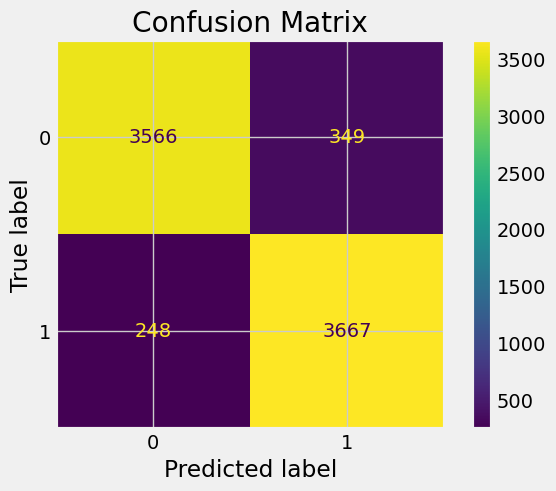

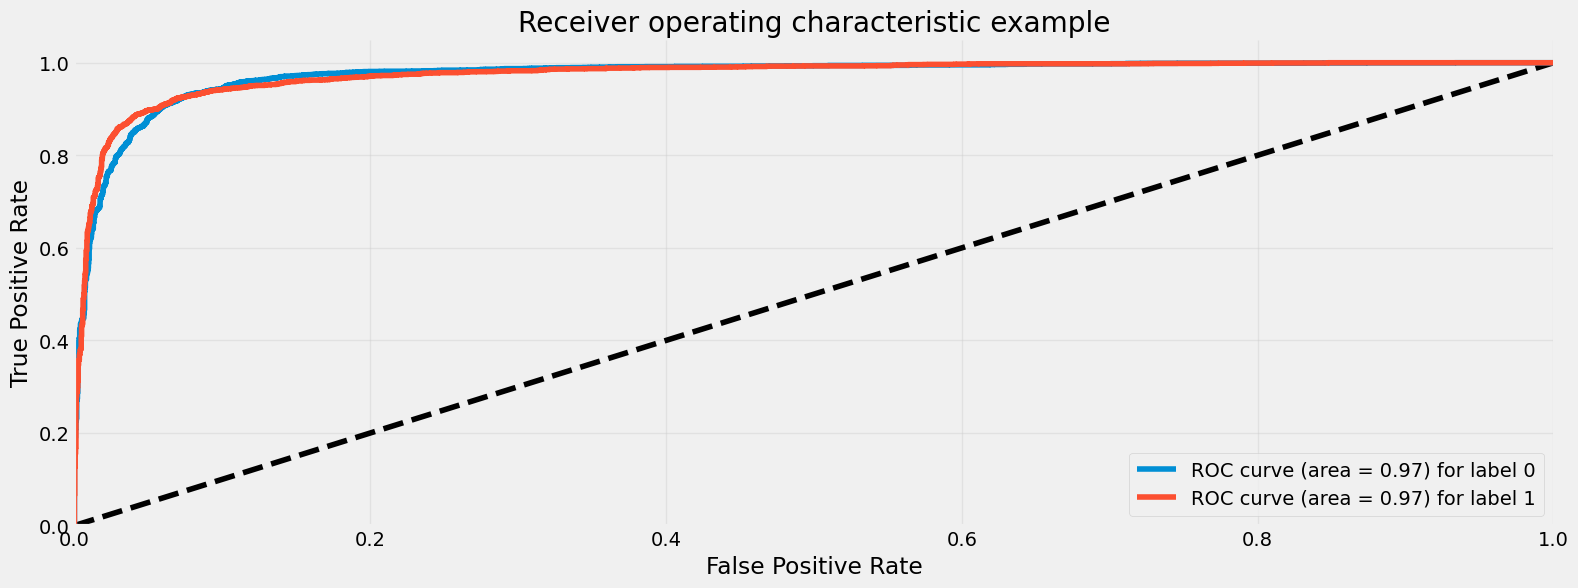

In [32]:
res = train_and_plot(pipeline, X_train = X_train_1, y_train = y_train_1, X_test = X_test_1, y_test = y_test_1)

## Task 2

In [33]:
X_train_task2, X_test_task2, y_train_task2, y_test_task2 = set_gen(task2, key = 'celltype')
print(X_train_task2.shape)
print(y_train_task2.shape)
print(X_test_task2.shape)
print(y_test_task2.shape)

(11376, 2187)
(11376,)
(4876, 2187)
(4876,)


[LightGBM] [Warning] Unknown parameter: use_label_encoder
Model accuracy for train set: 1.000
Model accuracy for test set: 0.904

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1219
           1       0.87      0.88      0.87      1219
           2       0.92      0.87      0.90      1219
           3       0.93      0.91      0.92      1219

    accuracy                           0.90      4876
   macro avg       0.90      0.90      0.90      4876
weighted avg       0.90      0.90      0.90      4876


Confusion Matrix:
 [[1162   26   23    8]
 [  37 1072   56   54]
 [  55   81 1066   17]
 [  37   57   17 1108]]

Accuracy Score:  0.904


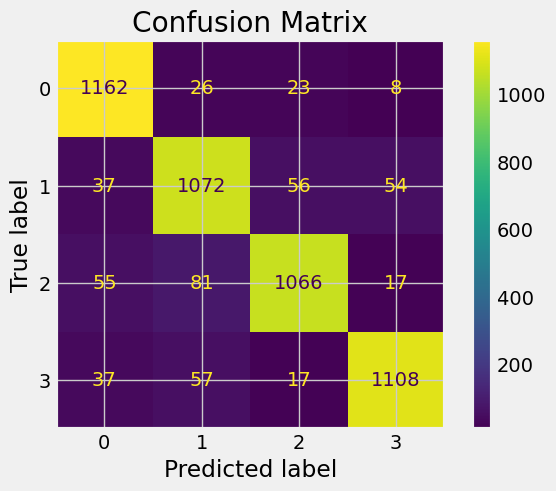

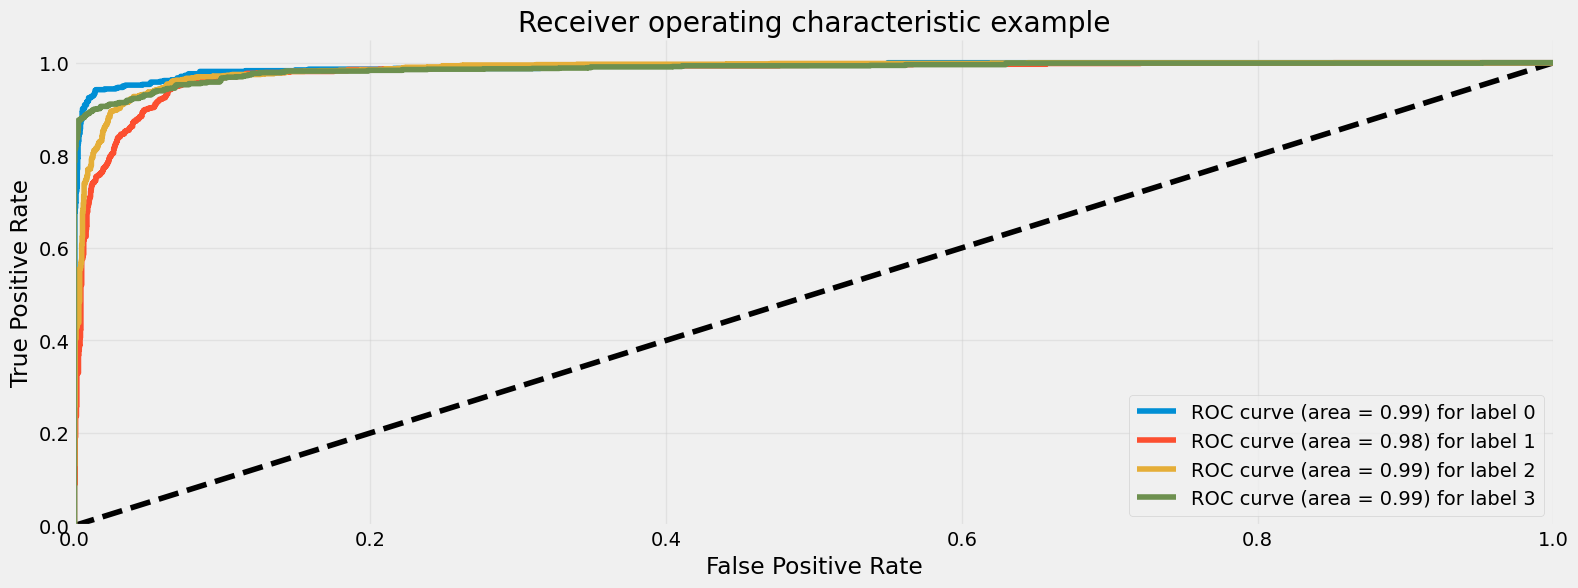

In [34]:
lgbm_clf = LGBMClassifier(random_state=42, use_label_encoder=False, n_jobs=-1)
lgbm_vanilla_task2 = train_and_plot(lgbm_clf, X_train_task2, y_train_task2, X_test_task2, y_test_task2)

## Tuned LightGBM model

In [41]:
def objective(trial):
    
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])
#Get minmax scaller

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    
    # -- Instantiate dimensionality reduction
     # (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, 40) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'
    
    pipeline = Pipeline([
        ("scaler", scaler),
        ("dim_red", dimen_red_algorithm),
        #Can change if gpu support is implementted
        ("lgbm", LGBMClassifier(n_jobs=-1))
    ])
    
        
    """Define the objective function"""
   
    params = {
        "lgbm__objective": "multiclass",
        "lgbm__metric": "multi_logloss",
        "lgbm__verbosity": -1,
        "lgbm__boosting_type": "gbdt",
        "lgbm__lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lgbm__lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "lgbm__num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "lgbm__feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "lgbm__bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "lgbm__bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "lgbm__min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # Fit the model
    model = pipeline.set_params(**params)
    model.fit(X_train_task2, y_train_task2)

    # Make predictions
    y_pred = model.predict(X_test_task2)

    # Evaluate predictions
    accuracy = accuracy_score(y_test_task2, y_pred)
    return accuracy

study2 = optuna.create_study(direction='maximize',
                            storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
                            study_name="task2_lgbmtuned_100_trail")

[I 2023-01-15 21:52:21,114] A new study created in RDB with name: task2_lgbmtuned_100_trail


In [42]:
study2.optimize(objective, n_trials=100)

[I 2023-01-15 21:52:36,526] Trial 0 finished with value: 0.8461853978671042 and parameters: {'scalers': 'robust', 'dim_red': 'PCA', 'pca_n_components': 9, 'lambda_l1': 1.570124669410769, 'lambda_l2': 0.004551421603578827, 'num_leaves': 126, 'feature_fraction': 0.9122140936110243, 'bagging_fraction': 0.5832522904107804, 'bagging_freq': 2, 'min_child_samples': 57}. Best is trial 0 with value: 0.8461853978671042.


[LightGBM] [Warning] feature_fraction is set=0.7571900091764754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7571900091764754
[LightGBM] [Warning] lambda_l1 is set=0.08320426910179253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08320426910179253
[LightGBM] [Warning] bagging_fraction is set=0.8689108885499148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8689108885499148
[LightGBM] [Warning] lambda_l2 is set=0.00012833622766525094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012833622766525094
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-01-15 21:54:18,887] Trial 1 finished with value: 0.9126333059885152 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.08320426910179253, 'lambda_l2': 0.00012833622766525094, 'num_leaves': 176, 'feature_fraction': 0.7571900091764754, 'bagging_fraction': 0.8689108885499148, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 1 with value: 0.9126333059885152.


[LightGBM] [Warning] feature_fraction is set=0.5900861628469907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5900861628469907
[LightGBM] [Warning] lambda_l1 is set=0.003887663081621913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003887663081621913
[LightGBM] [Warning] bagging_fraction is set=0.7959771040820451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7959771040820451
[LightGBM] [Warning] lambda_l2 is set=1.1867977264479956e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1867977264479956e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 21:55:10,911] Trial 2 finished with value: 0.9044298605414274 and parameters: {'scalers': 'robust', 'dim_red': 'PCA', 'pca_n_components': 29, 'lambda_l1': 0.003887663081621913, 'lambda_l2': 1.1867977264479956e-07, 'num_leaves': 164, 'feature_fraction': 0.5900861628469907, 'bagging_fraction': 0.7959771040820451, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 1 with value: 0.9126333059885152.


[LightGBM] [Warning] feature_fraction is set=0.7827265412261417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7827265412261417
[LightGBM] [Warning] lambda_l1 is set=5.288352990608522e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.288352990608522e-08
[LightGBM] [Warning] bagging_fraction is set=0.6128160159817398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6128160159817398
[LightGBM] [Warning] lambda_l2 is set=2.1411400331627815e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1411400331627815e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-01-15 21:55:32,685] Trial 3 finished with value: 0.9013535684987695 and parameters: {'scalers': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 29, 'lambda_l1': 5.288352990608522e-08, 'lambda_l2': 2.1411400331627815e-05, 'num_leaves': 178, 'feature_fraction': 0.7827265412261417, 'bagging_fraction': 0.6128160159817398, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 1 with value: 0.9126333059885152.


[LightGBM] [Warning] feature_fraction is set=0.9240371776525124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9240371776525124
[LightGBM] [Warning] lambda_l1 is set=1.403430512128382e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.403430512128382e-07
[LightGBM] [Warning] bagging_fraction is set=0.48387074206795677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48387074206795677
[LightGBM] [Warning] lambda_l2 is set=5.916128164961609e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.916128164961609e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-01-15 21:55:42,048] Trial 4 finished with value: 0.8619770303527482 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 23, 'lambda_l1': 1.403430512128382e-07, 'lambda_l2': 5.916128164961609e-08, 'num_leaves': 100, 'feature_fraction': 0.9240371776525124, 'bagging_fraction': 0.48387074206795677, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 1 with value: 0.9126333059885152.


[LightGBM] [Warning] feature_fraction is set=0.5909795591799333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5909795591799333
[LightGBM] [Warning] lambda_l1 is set=0.3710376252098996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3710376252098996
[LightGBM] [Warning] bagging_fraction is set=0.49844127808188643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49844127808188643
[LightGBM] [Warning] lambda_l2 is set=1.9172070402473793e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9172070402473793e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-01-15 21:56:12,254] Trial 5 finished with value: 0.9005332239540607 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.3710376252098996, 'lambda_l2': 1.9172070402473793e-08, 'num_leaves': 98, 'feature_fraction': 0.5909795591799333, 'bagging_fraction': 0.49844127808188643, 'bagging_freq': 6, 'min_child_samples': 90}. Best is trial 1 with value: 0.9126333059885152.


[LightGBM] [Warning] feature_fraction is set=0.8492743679284007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8492743679284007
[LightGBM] [Warning] lambda_l1 is set=3.593716452966042e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.593716452966042e-08
[LightGBM] [Warning] bagging_fraction is set=0.7568745700613213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7568745700613213
[LightGBM] [Warning] lambda_l2 is set=0.0038211049503136005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038211049503136005
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-01-15 21:56:23,868] Trial 6 finished with value: 0.8962264150943396 and parameters: {'scalers': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 21, 'lambda_l1': 3.593716452966042e-08, 'lambda_l2': 0.0038211049503136005, 'num_leaves': 114, 'feature_fraction': 0.8492743679284007, 'bagging_fraction': 0.7568745700613213, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 1 with value: 0.9126333059885152.


[LightGBM] [Warning] feature_fraction is set=0.46207972087630983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46207972087630983
[LightGBM] [Warning] lambda_l1 is set=0.001064250118578818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001064250118578818
[LightGBM] [Warning] bagging_fraction is set=0.90077464143654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.90077464143654
[LightGBM] [Warning] lambda_l2 is set=2.875375865894243e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.875375865894243e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-01-15 21:56:35,734] Trial 7 finished with value: 0.8796144380639869 and parameters: {'scalers': 'robust', 'dim_red': 'PCA', 'pca_n_components': 18, 'lambda_l1': 0.001064250118578818, 'lambda_l2': 2.875375865894243e-05, 'num_leaves': 47, 'feature_fraction': 0.46207972087630983, 'bagging_fraction': 0.90077464143654, 'bagging_freq': 2, 'min_child_samples': 23}. Best is trial 1 with value: 0.9126333059885152.


[LightGBM] [Warning] feature_fraction is set=0.5107680129652113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5107680129652113
[LightGBM] [Warning] lambda_l1 is set=0.29869004350512146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29869004350512146
[LightGBM] [Warning] bagging_fraction is set=0.5450701806682859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5450701806682859
[LightGBM] [Warning] lambda_l2 is set=1.3237727688135108e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3237727688135108e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-01-15 21:57:23,132] Trial 8 finished with value: 0.9105824446267432 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 0.29869004350512146, 'lambda_l2': 1.3237727688135108e-06, 'num_leaves': 161, 'feature_fraction': 0.5107680129652113, 'bagging_fraction': 0.5450701806682859, 'bagging_freq': 2, 'min_child_samples': 41}. Best is trial 1 with value: 0.9126333059885152.


[LightGBM] [Warning] feature_fraction is set=0.9771472339405464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9771472339405464
[LightGBM] [Warning] lambda_l1 is set=1.2919062449728653e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2919062449728653e-06
[LightGBM] [Warning] bagging_fraction is set=0.7361699045021317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7361699045021317
[LightGBM] [Warning] lambda_l2 is set=1.0042139950782848e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0042139950782848e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 21:58:21,927] Trial 9 finished with value: 0.9138638228055783 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 1.2919062449728653e-06, 'lambda_l2': 1.0042139950782848e-06, 'num_leaves': 87, 'feature_fraction': 0.9771472339405464, 'bagging_fraction': 0.7361699045021317, 'bagging_freq': 4, 'min_child_samples': 89}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.9989785210291903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9989785210291903
[LightGBM] [Warning] lambda_l1 is set=8.949331532692674e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.949331532692674e-06
[LightGBM] [Warning] bagging_fraction is set=0.6771811578902217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6771811578902217
[LightGBM] [Warning] lambda_l2 is set=1.3129484793987383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3129484793987383
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 21:59:12,779] Trial 10 finished with value: 0.9056603773584906 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 8.949331532692674e-06, 'lambda_l2': 1.3129484793987383, 'num_leaves': 248, 'feature_fraction': 0.9989785210291903, 'bagging_fraction': 0.6771811578902217, 'bagging_freq': 4, 'min_child_samples': 70}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.7138686442604365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7138686442604365
[LightGBM] [Warning] lambda_l1 is set=1.0462548039573111e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0462548039573111e-05
[LightGBM] [Warning] bagging_fraction is set=0.9761901806503521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9761901806503521
[LightGBM] [Warning] lambda_l2 is set=0.0003466973610758488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003466973610758488
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-01-15 21:59:27,150] Trial 11 finished with value: 0.8572600492206727 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 1.0462548039573111e-05, 'lambda_l2': 0.0003466973610758488, 'num_leaves': 13, 'feature_fraction': 0.7138686442604365, 'bagging_fraction': 0.9761901806503521, 'bagging_freq': 5, 'min_child_samples': 63}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.7394764428465048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7394764428465048
[LightGBM] [Warning] lambda_l1 is set=0.019646484946169468, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019646484946169468
[LightGBM] [Warning] bagging_fraction is set=0.8452330577103059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8452330577103059
[LightGBM] [Warning] lambda_l2 is set=1.7497664622005855e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7497664622005855e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 22:01:37,506] Trial 12 finished with value: 0.9073010664479081 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.019646484946169468, 'lambda_l2': 1.7497664622005855e-06, 'num_leaves': 227, 'feature_fraction': 0.7394764428465048, 'bagging_fraction': 0.8452330577103059, 'bagging_freq': 3, 'min_child_samples': 33}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.6156131735388107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6156131735388107
[LightGBM] [Warning] lambda_l1 is set=6.546464897170035e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.546464897170035e-05
[LightGBM] [Warning] bagging_fraction is set=0.7189839687515187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7189839687515187
[LightGBM] [Warning] lambda_l2 is set=0.13677535657955422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13677535657955422
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-01-15 22:02:22,126] Trial 13 finished with value: 0.9083264971287941 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 6.546464897170035e-05, 'lambda_l2': 0.13677535657955422, 'num_leaves': 71, 'feature_fraction': 0.6156131735388107, 'bagging_fraction': 0.7189839687515187, 'bagging_freq': 5, 'min_child_samples': 74}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.8380607828004142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380607828004142
[LightGBM] [Warning] lambda_l1 is set=1.938618034336561e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.938618034336561e-06
[LightGBM] [Warning] bagging_fraction is set=0.40718159701336654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40718159701336654
[LightGBM] [Warning] lambda_l2 is set=3.471726681361624e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.471726681361624e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-01-15 22:04:19,965] Trial 14 finished with value: 0.8990976210008204 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.938618034336561e-06, 'lambda_l2': 3.471726681361624e-05, 'num_leaves': 201, 'feature_fraction': 0.8380607828004142, 'bagging_fraction': 0.40718159701336654, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.9902816619815669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9902816619815669
[LightGBM] [Warning] lambda_l1 is set=7.832175002312112, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.832175002312112
[LightGBM] [Warning] bagging_fraction is set=0.9029486079065253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9029486079065253
[LightGBM] [Warning] lambda_l2 is set=0.0011536692951427576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011536692951427576
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-01-15 22:04:58,823] Trial 15 finished with value: 0.8993027071369976 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 7.832175002312112, 'lambda_l2': 0.0011536692951427576, 'num_leaves': 50, 'feature_fraction': 0.9902816619815669, 'bagging_fraction': 0.9029486079065253, 'bagging_freq': 1, 'min_child_samples': 50}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.6571983838474343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6571983838474343
[LightGBM] [Warning] lambda_l1 is set=0.019817984341317218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019817984341317218
[LightGBM] [Warning] bagging_fraction is set=0.9954105193253849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9954105193253849
[LightGBM] [Warning] lambda_l2 is set=1.0450230537996076e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0450230537996076e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-01-15 22:05:54,468] Trial 16 finished with value: 0.9101722723543888 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.019817984341317218, 'lambda_l2': 1.0450230537996076e-06, 'num_leaves': 149, 'feature_fraction': 0.6571983838474343, 'bagging_fraction': 0.9954105193253849, 'bagging_freq': 5, 'min_child_samples': 99}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.8242825088400187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8242825088400187
[LightGBM] [Warning] lambda_l1 is set=0.00021927847752285036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021927847752285036
[LightGBM] [Warning] bagging_fraction is set=0.6630697086951098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6630697086951098
[LightGBM] [Warning] lambda_l2 is set=1.2020970764364351e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2020970764364351e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 22:07:58,387] Trial 17 finished with value: 0.9134536505332239 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.00021927847752285036, 'lambda_l2': 1.2020970764364351e-05, 'num_leaves': 212, 'feature_fraction': 0.8242825088400187, 'bagging_fraction': 0.6630697086951098, 'bagging_freq': 3, 'min_child_samples': 33}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.9049956156166696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9049956156166696
[LightGBM] [Warning] lambda_l1 is set=1.327257897365226e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.327257897365226e-06
[LightGBM] [Warning] bagging_fraction is set=0.659418550563085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.659418550563085
[LightGBM] [Warning] lambda_l2 is set=5.093690262889138e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.093690262889138e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 22:11:04,943] Trial 18 finished with value: 0.9054552912223134 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 1.327257897365226e-06, 'lambda_l2': 5.093690262889138e-06, 'num_leaves': 202, 'feature_fraction': 0.9049956156166696, 'bagging_fraction': 0.659418550563085, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.82141764173941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.82141764173941
[LightGBM] [Warning] lambda_l1 is set=0.00016004895456515564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016004895456515564
[LightGBM] [Warning] bagging_fraction is set=0.7912464696875521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7912464696875521
[LightGBM] [Warning] lambda_l2 is set=1.8335192989721525e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8335192989721525e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 22:13:51,304] Trial 19 finished with value: 0.9062756357670222 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.00016004895456515564, 'lambda_l2': 1.8335192989721525e-07, 'num_leaves': 256, 'feature_fraction': 0.82141764173941, 'bagging_fraction': 0.7912464696875521, 'bagging_freq': 3, 'min_child_samples': 27}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.9256380967147538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9256380967147538
[LightGBM] [Warning] lambda_l1 is set=4.324326175409729e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.324326175409729e-07
[LightGBM] [Warning] bagging_fraction is set=0.6391902575093211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6391902575093211
[LightGBM] [Warning] lambda_l2 is set=0.025423727778381096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025423727778381096
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-01-15 22:15:10,751] Trial 20 finished with value: 0.9093519278096801 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 4.324326175409729e-07, 'lambda_l2': 0.025423727778381096, 'num_leaves': 83, 'feature_fraction': 0.9256380967147538, 'bagging_fraction': 0.6391902575093211, 'bagging_freq': 1, 'min_child_samples': 62}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.7639451185955923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7639451185955923
[LightGBM] [Warning] lambda_l1 is set=2.2121128869841865e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2121128869841865e-05
[LightGBM] [Warning] bagging_fraction is set=0.7346571496455697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7346571496455697
[LightGBM] [Warning] lambda_l2 is set=0.00012962574815261922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012962574815261922
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 22:17:25,950] Trial 21 finished with value: 0.912428219852338 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 2.2121128869841865e-05, 'lambda_l2': 0.00012962574815261922, 'num_leaves': 201, 'feature_fraction': 0.7639451185955923, 'bagging_fraction': 0.7346571496455697, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.6764949086540871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6764949086540871
[LightGBM] [Warning] lambda_l1 is set=0.002218594606446008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002218594606446008
[LightGBM] [Warning] bagging_fraction is set=0.8417450716847508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8417450716847508
[LightGBM] [Warning] lambda_l2 is set=7.423943046458678e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.423943046458678e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 22:19:27,411] Trial 22 finished with value: 0.9116078753076292 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.002218594606446008, 'lambda_l2': 7.423943046458678e-06, 'num_leaves': 145, 'feature_fraction': 0.6764949086540871, 'bagging_fraction': 0.8417450716847508, 'bagging_freq': 4, 'min_child_samples': 35}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.8673528768785884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8673528768785884
[LightGBM] [Warning] lambda_l1 is set=0.04141878353250561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04141878353250561
[LightGBM] [Warning] bagging_fraction is set=0.8894135631987075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8894135631987075
[LightGBM] [Warning] lambda_l2 is set=0.00025326332962955465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025326332962955465
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 22:21:06,380] Trial 23 finished with value: 0.9062756357670222 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.04141878353250561, 'lambda_l2': 0.00025326332962955465, 'num_leaves': 223, 'feature_fraction': 0.8673528768785884, 'bagging_fraction': 0.8894135631987075, 'bagging_freq': 3, 'min_child_samples': 46}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.7911713279870448, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7911713279870448
[LightGBM] [Warning] lambda_l1 is set=0.00043018792631081864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00043018792631081864
[LightGBM] [Warning] bagging_fraction is set=0.698421312369828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.698421312369828
[LightGBM] [Warning] lambda_l2 is set=2.7964656709118864e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7964656709118864e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-01-15 22:23:39,995] Trial 24 finished with value: 0.911402789171452 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.00043018792631081864, 'lambda_l2': 2.7964656709118864e-07, 'num_leaves': 183, 'feature_fraction': 0.7911713279870448, 'bagging_fraction': 0.698421312369828, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.9617934575366027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9617934575366027
[LightGBM] [Warning] lambda_l1 is set=8.872872777256772e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.872872777256772e-05
[LightGBM] [Warning] bagging_fraction is set=0.7813520980837877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7813520980837877
[LightGBM] [Warning] lambda_l2 is set=8.771635134289342e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.771635134289342e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 22:26:25,788] Trial 25 finished with value: 0.9116078753076292 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 8.872872777256772e-05, 'lambda_l2': 8.771635134289342e-05, 'num_leaves': 224, 'feature_fraction': 0.9617934575366027, 'bagging_fraction': 0.7813520980837877, 'bagging_freq': 4, 'min_child_samples': 30}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.8689955795658207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8689955795658207
[LightGBM] [Warning] lambda_l1 is set=0.07647652272873745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07647652272873745
[LightGBM] [Warning] bagging_fraction is set=0.9338916668354502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9338916668354502
[LightGBM] [Warning] lambda_l2 is set=6.927120174161693e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.927120174161693e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-01-15 22:27:43,394] Trial 26 finished with value: 0.9101722723543888 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.07647652272873745, 'lambda_l2': 6.927120174161693e-06, 'num_leaves': 133, 'feature_fraction': 0.8689955795658207, 'bagging_fraction': 0.9338916668354502, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.8014329419360758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8014329419360758
[LightGBM] [Warning] lambda_l1 is set=0.006098882369410591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006098882369410591
[LightGBM] [Warning] bagging_fraction is set=0.8505995391884635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505995391884635
[LightGBM] [Warning] lambda_l2 is set=1.650631354218907e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.650631354218907e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 22:27:49,963] Trial 27 finished with value: 0.7251845775225595 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.006098882369410591, 'lambda_l2': 1.650631354218907e-08, 'num_leaves': 4, 'feature_fraction': 0.8014329419360758, 'bagging_fraction': 0.8505995391884635, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.7278185865224271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7278185865224271
[LightGBM] [Warning] lambda_l1 is set=1.1117240344882306e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1117240344882306e-08
[LightGBM] [Warning] bagging_fraction is set=0.5822612965748653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5822612965748653
[LightGBM] [Warning] lambda_l2 is set=0.0016191017194985924, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016191017194985924
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-01-15 22:28:31,713] Trial 28 finished with value: 0.9105824446267432 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 1.1117240344882306e-08, 'lambda_l2': 0.0016191017194985924, 'num_leaves': 180, 'feature_fraction': 0.7278185865224271, 'bagging_fraction': 0.5822612965748653, 'bagging_freq': 2, 'min_child_samples': 78}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.8971524772371794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8971524772371794
[LightGBM] [Warning] lambda_l1 is set=4.623814550980545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.623814550980545
[LightGBM] [Warning] bagging_fraction is set=0.6121422483369745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6121422483369745
[LightGBM] [Warning] lambda_l2 is set=0.03064768964225122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03064768964225122
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-01-15 22:28:41,057] Trial 29 finished with value: 0.8652584085315833 and parameters: {'scalers': 'robust', 'dim_red': 'PCA', 'pca_n_components': 39, 'lambda_l1': 4.623814550980545, 'lambda_l2': 0.03064768964225122, 'num_leaves': 137, 'feature_fraction': 0.8971524772371794, 'bagging_fraction': 0.6121422483369745, 'bagging_freq': 5, 'min_child_samples': 65}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.943853646092012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.943853646092012
[LightGBM] [Warning] lambda_l1 is set=0.7175203915816842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7175203915816842
[LightGBM] [Warning] bagging_fraction is set=0.8107059715537996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8107059715537996
[LightGBM] [Warning] lambda_l2 is set=4.368781679109563e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.368781679109563e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-01-15 22:29:38,259] Trial 30 finished with value: 0.9054552912223134 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 0.7175203915816842, 'lambda_l2': 4.368781679109563e-07, 'num_leaves': 121, 'feature_fraction': 0.943853646092012, 'bagging_fraction': 0.8107059715537996, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.7526293289586947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7526293289586947
[LightGBM] [Warning] lambda_l1 is set=1.9380980535641486e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9380980535641486e-05
[LightGBM] [Warning] bagging_fraction is set=0.7234880026356791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7234880026356791
[LightGBM] [Warning] lambda_l2 is set=0.0001263806423865339, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001263806423865339
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 22:32:03,912] Trial 31 finished with value: 0.9097621000820345 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 1.9380980535641486e-05, 'lambda_l2': 0.0001263806423865339, 'num_leaves': 212, 'feature_fraction': 0.7526293289586947, 'bagging_fraction': 0.7234880026356791, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.7679223633386183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7679223633386183
[LightGBM] [Warning] lambda_l1 is set=2.281663382710937e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.281663382710937e-06
[LightGBM] [Warning] bagging_fraction is set=0.744220793434995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.744220793434995
[LightGBM] [Warning] lambda_l2 is set=0.0007060680548680126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007060680548680126
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 22:33:51,056] Trial 32 finished with value: 0.9116078753076292 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 2.281663382710937e-06, 'lambda_l2': 0.0007060680548680126, 'num_leaves': 197, 'feature_fraction': 0.7679223633386183, 'bagging_fraction': 0.744220793434995, 'bagging_freq': 4, 'min_child_samples': 42}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.6615581231510077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6615581231510077
[LightGBM] [Warning] lambda_l1 is set=2.2708214597622025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2708214597622025e-05
[LightGBM] [Warning] bagging_fraction is set=0.6842406428252827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6842406428252827
[LightGBM] [Warning] lambda_l2 is set=6.854557850919486e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.854557850919486e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 22:35:25,253] Trial 33 finished with value: 0.910377358490566 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 2.2708214597622025e-05, 'lambda_l2': 6.854557850919486e-05, 'num_leaves': 165, 'feature_fraction': 0.6615581231510077, 'bagging_fraction': 0.6842406428252827, 'bagging_freq': 4, 'min_child_samples': 45}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.6951997585243418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6951997585243418
[LightGBM] [Warning] lambda_l1 is set=0.0006962297733612436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006962297733612436
[LightGBM] [Warning] bagging_fraction is set=0.7545119480327949, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7545119480327949
[LightGBM] [Warning] lambda_l2 is set=1.4812251655375354e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4812251655375354e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 22:35:47,759] Trial 34 finished with value: 0.73318293683347 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 4, 'lambda_l1': 0.0006962297733612436, 'lambda_l2': 1.4812251655375354e-05, 'num_leaves': 241, 'feature_fraction': 0.6951997585243418, 'bagging_fraction': 0.7545119480327949, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.7817028162836119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7817028162836119
[LightGBM] [Warning] lambda_l1 is set=6.634438799731829e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.634438799731829e-07
[LightGBM] [Warning] bagging_fraction is set=0.6344436486822217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6344436486822217
[LightGBM] [Warning] lambda_l2 is set=3.836863211374138e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.836863211374138e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 22:37:18,232] Trial 35 finished with value: 0.9081214109926169 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 6.634438799731829e-07, 'lambda_l2': 3.836863211374138e-06, 'num_leaves': 194, 'feature_fraction': 0.7817028162836119, 'bagging_fraction': 0.6344436486822217, 'bagging_freq': 4, 'min_child_samples': 53}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.6305689107025917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6305689107025917
[LightGBM] [Warning] lambda_l1 is set=4.123542942236128e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.123542942236128e-05
[LightGBM] [Warning] bagging_fraction is set=0.5472247958126535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5472247958126535
[LightGBM] [Warning] lambda_l2 is set=0.009684927270179175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009684927270179175
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-01-15 22:37:41,782] Trial 36 finished with value: 0.9038146021328958 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 40, 'lambda_l1': 4.123542942236128e-05, 'lambda_l2': 0.009684927270179175, 'num_leaves': 162, 'feature_fraction': 0.6305689107025917, 'bagging_fraction': 0.5472247958126535, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.8205033971855028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8205033971855028
[LightGBM] [Warning] lambda_l1 is set=1.523622267421571e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.523622267421571e-07
[LightGBM] [Warning] bagging_fraction is set=0.7185831278536498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7185831278536498
[LightGBM] [Warning] lambda_l2 is set=1.740169334343326e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.740169334343326e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-01-15 22:38:52,917] Trial 37 finished with value: 0.9111977030352748 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.523622267421571e-07, 'lambda_l2': 1.740169334343326e-05, 'num_leaves': 237, 'feature_fraction': 0.8205033971855028, 'bagging_fraction': 0.7185831278536498, 'bagging_freq': 5, 'min_child_samples': 89}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.8560881778165337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8560881778165337
[LightGBM] [Warning] lambda_l1 is set=4.2389539024888425e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2389539024888425e-06
[LightGBM] [Warning] bagging_fraction is set=0.8150947284271819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8150947284271819
[LightGBM] [Warning] lambda_l2 is set=4.0596737517282923e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0596737517282923e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-01-15 22:39:14,679] Trial 38 finished with value: 0.8910992616899097 and parameters: {'scalers': 'robust', 'dim_red': 'PCA', 'pca_n_components': 13, 'lambda_l1': 4.2389539024888425e-06, 'lambda_l2': 4.0596737517282923e-08, 'num_leaves': 94, 'feature_fraction': 0.8560881778165337, 'bagging_fraction': 0.8150947284271819, 'bagging_freq': 2, 'min_child_samples': 50}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.877947958193294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.877947958193294
[LightGBM] [Warning] lambda_l1 is set=0.004148377374650911, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004148377374650911
[LightGBM] [Warning] bagging_fraction is set=0.7717657986029898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7717657986029898
[LightGBM] [Warning] lambda_l2 is set=0.00020396169955533928, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020396169955533928
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 22:41:21,972] Trial 39 finished with value: 0.9095570139458573 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.004148377374650911, 'lambda_l2': 0.00020396169955533928, 'num_leaves': 114, 'feature_fraction': 0.877947958193294, 'bagging_fraction': 0.7717657986029898, 'bagging_freq': 3, 'min_child_samples': 12}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.49863400230298327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49863400230298327
[LightGBM] [Warning] lambda_l1 is set=0.0002503632934172937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002503632934172937
[LightGBM] [Warning] bagging_fraction is set=0.5728892787888813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5728892787888813
[LightGBM] [Warning] lambda_l2 is set=7.570302665744085e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.570302665744085e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 22:43:25,931] Trial 40 finished with value: 0.9120180475799836 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 0.0002503632934172937, 'lambda_l2': 7.570302665744085e-08, 'num_leaves': 213, 'feature_fraction': 0.49863400230298327, 'bagging_fraction': 0.5728892787888813, 'bagging_freq': 4, 'min_child_samples': 26}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.5320074452651693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5320074452651693
[LightGBM] [Warning] lambda_l1 is set=0.00024951091465231535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024951091465231535
[LightGBM] [Warning] bagging_fraction is set=0.5741651372978827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5741651372978827
[LightGBM] [Warning] lambda_l2 is set=7.159276866015093e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.159276866015093e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 22:45:58,294] Trial 41 finished with value: 0.9083264971287941 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 0.00024951091465231535, 'lambda_l2': 7.159276866015093e-08, 'num_leaves': 214, 'feature_fraction': 0.5320074452651693, 'bagging_fraction': 0.5741651372978827, 'bagging_freq': 4, 'min_child_samples': 23}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.43662226114230324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43662226114230324
[LightGBM] [Warning] lambda_l1 is set=0.0009521538162719805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009521538162719805
[LightGBM] [Warning] bagging_fraction is set=0.5001152276597075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5001152276597075
[LightGBM] [Warning] lambda_l2 is set=4.585585919310201e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.585585919310201e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-01-15 22:49:33,478] Trial 42 finished with value: 0.910377358490566 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 0.0009521538162719805, 'lambda_l2': 4.585585919310201e-07, 'num_leaves': 186, 'feature_fraction': 0.43662226114230324, 'bagging_fraction': 0.5001152276597075, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.5477925349698112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5477925349698112
[LightGBM] [Warning] lambda_l1 is set=7.001672464681205e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.001672464681205e-06
[LightGBM] [Warning] bagging_fraction is set=0.6085610000959296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6085610000959296
[LightGBM] [Warning] lambda_l2 is set=1.867769921545354e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.867769921545354e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 22:52:26,606] Trial 43 finished with value: 0.9056603773584906 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 7.001672464681205e-06, 'lambda_l2': 1.867769921545354e-06, 'num_leaves': 212, 'feature_fraction': 0.5477925349698112, 'bagging_fraction': 0.6085610000959296, 'bagging_freq': 3, 'min_child_samples': 33}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.5751996907675705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5751996907675705
[LightGBM] [Warning] lambda_l1 is set=8.913107241341864e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.913107241341864e-05
[LightGBM] [Warning] bagging_fraction is set=0.4675052476132928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4675052476132928
[LightGBM] [Warning] lambda_l2 is set=4.99177854062334e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.99177854062334e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 22:54:14,112] Trial 44 finished with value: 0.9093519278096801 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 8.913107241341864e-05, 'lambda_l2': 4.99177854062334e-05, 'num_leaves': 171, 'feature_fraction': 0.5751996907675705, 'bagging_fraction': 0.4675052476132928, 'bagging_freq': 4, 'min_child_samples': 43}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.7490171157933541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7490171157933541
[LightGBM] [Warning] lambda_l1 is set=0.00186515320637357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00186515320637357
[LightGBM] [Warning] bagging_fraction is set=0.513748103887535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.513748103887535
[LightGBM] [Warning] lambda_l2 is set=1.240056747417226e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.240056747417226e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 22:55:41,347] Trial 45 finished with value: 0.9062756357670222 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 0.00186515320637357, 'lambda_l2': 1.240056747417226e-07, 'num_leaves': 62, 'feature_fraction': 0.7490171157933541, 'bagging_fraction': 0.513748103887535, 'bagging_freq': 4, 'min_child_samples': 27}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.4106903647432768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4106903647432768
[LightGBM] [Warning] lambda_l1 is set=2.7451275490600417e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7451275490600417e-05
[LightGBM] [Warning] bagging_fraction is set=0.6607083162240035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6607083162240035
[LightGBM] [Warning] lambda_l2 is set=1.1085769216541094e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1085769216541094e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-01-15 22:55:53,363] Trial 46 finished with value: 0.8673092698933552 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 31, 'lambda_l1': 2.7451275490600417e-05, 'lambda_l2': 1.1085769216541094e-08, 'num_leaves': 34, 'feature_fraction': 0.4106903647432768, 'bagging_fraction': 0.6607083162240035, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.48184349778754515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48184349778754515
[LightGBM] [Warning] lambda_l1 is set=0.00032258296176628323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00032258296176628323
[LightGBM] [Warning] bagging_fraction is set=0.5481277731589349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5481277731589349
[LightGBM] [Warning] lambda_l2 is set=5.504707960953403e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.504707960953403e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-01-15 22:57:36,425] Trial 47 finished with value: 0.9111977030352748 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 0.00032258296176628323, 'lambda_l2': 5.504707960953403e-07, 'num_leaves': 233, 'feature_fraction': 0.48184349778754515, 'bagging_fraction': 0.5481277731589349, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.6868776749650519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6868776749650519
[LightGBM] [Warning] lambda_l1 is set=0.1541727608948868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1541727608948868
[LightGBM] [Warning] bagging_fraction is set=0.872566876368386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.872566876368386
[LightGBM] [Warning] lambda_l2 is set=3.4367705219465465e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4367705219465465e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-01-15 22:58:47,733] Trial 48 finished with value: 0.9120180475799836 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.1541727608948868, 'lambda_l2': 3.4367705219465465e-08, 'num_leaves': 152, 'feature_fraction': 0.6868776749650519, 'bagging_fraction': 0.872566876368386, 'bagging_freq': 2, 'min_child_samples': 84}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.7025160149383863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7025160149383863
[LightGBM] [Warning] lambda_l1 is set=0.34139673821694383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34139673821694383
[LightGBM] [Warning] bagging_fraction is set=0.9510984979649044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9510984979649044
[LightGBM] [Warning] lambda_l2 is set=5.644101986094061, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.644101986094061
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-01-15 22:59:45,389] Trial 49 finished with value: 0.9062756357670222 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.34139673821694383, 'lambda_l2': 5.644101986094061, 'num_leaves': 101, 'feature_fraction': 0.7025160149383863, 'bagging_fraction': 0.9510984979649044, 'bagging_freq': 2, 'min_child_samples': 86}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.6384463581484175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6384463581484175
[LightGBM] [Warning] lambda_l1 is set=0.14413022562180874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14413022562180874
[LightGBM] [Warning] bagging_fraction is set=0.8758539688853487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8758539688853487
[LightGBM] [Warning] lambda_l2 is set=0.0004914106410408087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004914106410408087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-01-15 23:09:12,515] Trial 50 finished with value: 0.9101722723543888 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.14413022562180874, 'lambda_l2': 0.0004914106410408087, 'num_leaves': 147, 'feature_fraction': 0.6384463581484175, 'bagging_fraction': 0.8758539688853487, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.724731522707555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.724731522707555
[LightGBM] [Warning] lambda_l1 is set=0.011047689161011247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011047689161011247
[LightGBM] [Warning] bagging_fraction is set=0.8142235056428166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8142235056428166
[LightGBM] [Warning] lambda_l2 is set=4.170593360144713e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.170593360144713e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-01-15 23:18:43,329] Trial 51 finished with value: 0.9122231337161608 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.011047689161011247, 'lambda_l2': 4.170593360144713e-08, 'num_leaves': 173, 'feature_fraction': 0.724731522707555, 'bagging_fraction': 0.8142235056428166, 'bagging_freq': 2, 'min_child_samples': 94}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.7220339699139984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7220339699139984
[LightGBM] [Warning] lambda_l1 is set=0.017066667335182674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017066667335182674
[LightGBM] [Warning] bagging_fraction is set=0.8228923600471284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8228923600471284
[LightGBM] [Warning] lambda_l2 is set=3.903101500630856e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.903101500630856e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-01-15 23:20:08,102] Trial 52 finished with value: 0.9091468416735029 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.017066667335182674, 'lambda_l2': 3.903101500630856e-08, 'num_leaves': 156, 'feature_fraction': 0.7220339699139984, 'bagging_fraction': 0.8228923600471284, 'bagging_freq': 2, 'min_child_samples': 82}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.6850281530684674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6850281530684674
[LightGBM] [Warning] lambda_l1 is set=1.155210073810888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.155210073810888
[LightGBM] [Warning] bagging_fraction is set=0.8703748795701655, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8703748795701655
[LightGBM] [Warning] lambda_l2 is set=2.547561442292319e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.547561442292319e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-01-15 23:21:09,515] Trial 53 finished with value: 0.9091468416735029 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 1.155210073810888, 'lambda_l2': 2.547561442292319e-06, 'num_leaves': 173, 'feature_fraction': 0.6850281530684674, 'bagging_fraction': 0.8703748795701655, 'bagging_freq': 2, 'min_child_samples': 90}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.8179062857894213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8179062857894213
[LightGBM] [Warning] lambda_l1 is set=0.008455214323051845, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008455214323051845
[LightGBM] [Warning] bagging_fraction is set=0.9114454105665653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9114454105665653
[LightGBM] [Warning] lambda_l2 is set=1.0201150234098915e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0201150234098915e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-01-15 23:22:39,592] Trial 54 finished with value: 0.9066858080393765 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.008455214323051845, 'lambda_l2': 1.0201150234098915e-06, 'num_leaves': 191, 'feature_fraction': 0.8179062857894213, 'bagging_fraction': 0.9114454105665653, 'bagging_freq': 1, 'min_child_samples': 95}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.7644169841727358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7644169841727358
[LightGBM] [Warning] lambda_l1 is set=0.10696995518737035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10696995518737035
[LightGBM] [Warning] bagging_fraction is set=0.7316133568005996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7316133568005996
[LightGBM] [Warning] lambda_l2 is set=1.3584700491633942e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3584700491633942e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 23:24:14,939] Trial 55 finished with value: 0.9068908941755537 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.10696995518737035, 'lambda_l2': 1.3584700491633942e-05, 'num_leaves': 155, 'feature_fraction': 0.7644169841727358, 'bagging_fraction': 0.7316133568005996, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.7304158626332434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7304158626332434
[LightGBM] [Warning] lambda_l1 is set=0.02407493630917489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02407493630917489
[LightGBM] [Warning] bagging_fraction is set=0.8378628536529261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8378628536529261
[LightGBM] [Warning] lambda_l2 is set=2.714575414232018e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.714575414232018e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-01-15 23:25:21,021] Trial 56 finished with value: 0.9118129614438064 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.02407493630917489, 'lambda_l2': 2.714575414232018e-08, 'num_leaves': 202, 'feature_fraction': 0.7304158626332434, 'bagging_fraction': 0.8378628536529261, 'bagging_freq': 2, 'min_child_samples': 95}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.6642514107210249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6642514107210249
[LightGBM] [Warning] lambda_l1 is set=0.052763768247530166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.052763768247530166
[LightGBM] [Warning] bagging_fraction is set=0.7854803506487252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7854803506487252
[LightGBM] [Warning] lambda_l2 is set=1.5440683789754505e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5440683789754505e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-01-15 23:27:46,638] Trial 57 finished with value: 0.9087366694011485 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.052763768247530166, 'lambda_l2': 1.5440683789754505e-07, 'num_leaves': 172, 'feature_fraction': 0.6642514107210249, 'bagging_fraction': 0.7854803506487252, 'bagging_freq': 2, 'min_child_samples': 74}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.836473918675005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.836473918675005
[LightGBM] [Warning] lambda_l1 is set=0.1954182836921614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1954182836921614
[LightGBM] [Warning] bagging_fraction is set=0.9264449863306544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9264449863306544
[LightGBM] [Warning] lambda_l2 is set=0.0022809834202403762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022809834202403762
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 23:29:20,834] Trial 58 finished with value: 0.9079163248564397 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.1954182836921614, 'lambda_l2': 0.0022809834202403762, 'num_leaves': 141, 'feature_fraction': 0.836473918675005, 'bagging_fraction': 0.9264449863306544, 'bagging_freq': 3, 'min_child_samples': 77}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.7089722640108717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7089722640108717
[LightGBM] [Warning] lambda_l1 is set=2.8121977958891082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8121977958891082
[LightGBM] [Warning] bagging_fraction is set=0.7053507656523633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7053507656523633
[LightGBM] [Warning] lambda_l2 is set=3.132438588852469e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.132438588852469e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-01-15 23:29:35,286] Trial 59 finished with value: 0.48461853978671043 and parameters: {'scalers': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 3, 'lambda_l1': 2.8121977958891082, 'lambda_l2': 3.132438588852469e-05, 'num_leaves': 127, 'feature_fraction': 0.7089722640108717, 'bagging_fraction': 0.7053507656523633, 'bagging_freq': 1, 'min_child_samples': 91}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.8041562433556038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8041562433556038
[LightGBM] [Warning] lambda_l1 is set=0.00015693669300283802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015693669300283802
[LightGBM] [Warning] bagging_fraction is set=0.7697494700205583, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7697494700205583
[LightGBM] [Warning] lambda_l2 is set=0.00015458913737601227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015458913737601227
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 23:32:50,892] Trial 60 finished with value: 0.9095570139458573 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 0.00015693669300283802, 'lambda_l2': 0.00015458913737601227, 'num_leaves': 219, 'feature_fraction': 0.8041562433556038, 'bagging_fraction': 0.7697494700205583, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.6069446275727459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6069446275727459
[LightGBM] [Warning] lambda_l1 is set=0.0018521552955389619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018521552955389619
[LightGBM] [Warning] bagging_fraction is set=0.8019599372755759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019599372755759
[LightGBM] [Warning] lambda_l2 is set=8.94311790060583e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.94311790060583e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 23:33:50,035] Trial 61 finished with value: 0.9064807219031994 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.0018521552955389619, 'lambda_l2': 8.94311790060583e-08, 'num_leaves': 206, 'feature_fraction': 0.6069446275727459, 'bagging_fraction': 0.8019599372755759, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.7731486227246058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7731486227246058
[LightGBM] [Warning] lambda_l1 is set=0.5725831696648769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5725831696648769
[LightGBM] [Warning] bagging_fraction is set=0.6767067941597624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6767067941597624
[LightGBM] [Warning] lambda_l2 is set=2.521674731976664e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.521674731976664e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-01-15 23:35:29,826] Trial 62 finished with value: 0.9062756357670222 and parameters: {'scalers': 'minmax', 'dim_red': None, 'lambda_l1': 0.5725831696648769, 'lambda_l2': 2.521674731976664e-07, 'num_leaves': 185, 'feature_fraction': 0.7731486227246058, 'bagging_fraction': 0.6767067941597624, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 9 with value: 0.9138638228055783.


[LightGBM] [Warning] feature_fraction is set=0.9840355098240596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9840355098240596
[LightGBM] [Warning] lambda_l1 is set=0.011508037597462427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011508037597462427
[LightGBM] [Warning] bagging_fraction is set=0.8635734699884771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8635734699884771
[LightGBM] [Warning] lambda_l2 is set=1.1301506734594464e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1301506734594464e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 23:37:33,106] Trial 63 finished with value: 0.9161197703035275 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.011508037597462427, 'lambda_l2': 1.1301506734594464e-08, 'num_leaves': 248, 'feature_fraction': 0.9840355098240596, 'bagging_fraction': 0.8635734699884771, 'bagging_freq': 4, 'min_child_samples': 68}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9738714911043529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9738714911043529
[LightGBM] [Warning] lambda_l1 is set=0.015677761728768537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015677761728768537
[LightGBM] [Warning] bagging_fraction is set=0.8527340926795332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8527340926795332
[LightGBM] [Warning] lambda_l2 is set=1.691908762044926e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.691908762044926e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 23:39:10,994] Trial 64 finished with value: 0.9128383921246924 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.015677761728768537, 'lambda_l2': 1.691908762044926e-08, 'num_leaves': 256, 'feature_fraction': 0.9738714911043529, 'bagging_fraction': 0.8527340926795332, 'bagging_freq': 3, 'min_child_samples': 69}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9750000256771563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9750000256771563
[LightGBM] [Warning] lambda_l1 is set=0.011628009035594498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011628009035594498
[LightGBM] [Warning] bagging_fraction is set=0.8454305185134735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8454305185134735
[LightGBM] [Warning] lambda_l2 is set=1.0707114095174383e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0707114095174383e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 23:40:48,247] Trial 65 finished with value: 0.9118129614438064 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.011628009035594498, 'lambda_l2': 1.0707114095174383e-08, 'num_leaves': 232, 'feature_fraction': 0.9750000256771563, 'bagging_fraction': 0.8454305185134735, 'bagging_freq': 3, 'min_child_samples': 67}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9295795846705266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9295795846705266
[LightGBM] [Warning] lambda_l1 is set=0.04362840233939499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04362840233939499
[LightGBM] [Warning] bagging_fraction is set=0.8246737156201049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8246737156201049
[LightGBM] [Warning] lambda_l2 is set=2.2154257784133578e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2154257784133578e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 23:42:23,119] Trial 66 finished with value: 0.9083264971287941 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.04362840233939499, 'lambda_l2': 2.2154257784133578e-08, 'num_leaves': 256, 'feature_fraction': 0.9295795846705266, 'bagging_fraction': 0.8246737156201049, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9953835390052386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9953835390052386
[LightGBM] [Warning] lambda_l1 is set=0.0030914179656315417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030914179656315417
[LightGBM] [Warning] bagging_fraction is set=0.8890792612706078, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8890792612706078
[LightGBM] [Warning] lambda_l2 is set=7.573552953648517e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.573552953648517e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 23:44:29,716] Trial 67 finished with value: 0.9107875307629204 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.0030914179656315417, 'lambda_l2': 7.573552953648517e-06, 'num_leaves': 228, 'feature_fraction': 0.9953835390052386, 'bagging_fraction': 0.8890792612706078, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9525260032271035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9525260032271035
[LightGBM] [Warning] lambda_l1 is set=1.4156554182067388e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4156554182067388e-07
[LightGBM] [Warning] bagging_fraction is set=0.9694705277952761, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9694705277952761
[LightGBM] [Warning] lambda_l2 is set=9.107844420438671e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.107844420438671e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-01-15 23:46:34,413] Trial 68 finished with value: 0.911402789171452 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 1.4156554182067388e-07, 'lambda_l2': 9.107844420438671e-07, 'num_leaves': 255, 'feature_fraction': 0.9525260032271035, 'bagging_fraction': 0.9694705277952761, 'bagging_freq': 5, 'min_child_samples': 69}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.8985531042397881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8985531042397881
[LightGBM] [Warning] lambda_l1 is set=0.0006465574034785379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006465574034785379
[LightGBM] [Warning] bagging_fraction is set=0.7460809224921148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7460809224921148
[LightGBM] [Warning] lambda_l2 is set=0.00036500703547989526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00036500703547989526
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 23:48:16,070] Trial 69 finished with value: 0.9136587366694011 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.0006465574034785379, 'lambda_l2': 0.00036500703547989526, 'num_leaves': 243, 'feature_fraction': 0.8985531042397881, 'bagging_fraction': 0.7460809224921148, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.8983941699163753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8983941699163753
[LightGBM] [Warning] lambda_l1 is set=1.0772653294640395e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0772653294640395e-05
[LightGBM] [Warning] bagging_fraction is set=0.7486471959670207, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7486471959670207
[LightGBM] [Warning] lambda_l2 is set=0.0005016919584651642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005016919584651642
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 23:50:00,985] Trial 70 finished with value: 0.911402789171452 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 1.0772653294640395e-05, 'lambda_l2': 0.0005016919584651642, 'num_leaves': 249, 'feature_fraction': 0.8983941699163753, 'bagging_fraction': 0.7486471959670207, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9684694905057754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9684694905057754
[LightGBM] [Warning] lambda_l1 is set=0.005028074007290864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005028074007290864
[LightGBM] [Warning] bagging_fraction is set=0.6928304245684711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6928304245684711
[LightGBM] [Warning] lambda_l2 is set=0.0011048598192263822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011048598192263822
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 23:51:14,259] Trial 71 finished with value: 0.910377358490566 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.005028074007290864, 'lambda_l2': 0.0011048598192263822, 'num_leaves': 243, 'feature_fraction': 0.9684694905057754, 'bagging_fraction': 0.6928304245684711, 'bagging_freq': 4, 'min_child_samples': 75}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9352847336104282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9352847336104282
[LightGBM] [Warning] lambda_l1 is set=0.0005852156789361512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005852156789361512
[LightGBM] [Warning] bagging_fraction is set=0.8582134121761179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8582134121761179
[LightGBM] [Warning] lambda_l2 is set=1.638890006723357e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.638890006723357e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-01-15 23:52:52,325] Trial 72 finished with value: 0.9066858080393765 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.0005852156789361512, 'lambda_l2': 1.638890006723357e-08, 'num_leaves': 247, 'feature_fraction': 0.9352847336104282, 'bagging_fraction': 0.8582134121761179, 'bagging_freq': 5, 'min_child_samples': 69}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.916685418060269, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.916685418060269
[LightGBM] [Warning] lambda_l1 is set=0.03258120045630975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03258120045630975
[LightGBM] [Warning] bagging_fraction is set=0.7677164104418365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7677164104418365
[LightGBM] [Warning] lambda_l2 is set=0.004480409682578742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004480409682578742
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 23:54:39,408] Trial 73 finished with value: 0.9097621000820345 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.03258120045630975, 'lambda_l2': 0.004480409682578742, 'num_leaves': 235, 'feature_fraction': 0.916685418060269, 'bagging_fraction': 0.7677164104418365, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9780520951141681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9780520951141681
[LightGBM] [Warning] lambda_l1 is set=0.0011304597646462887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011304597646462887
[LightGBM] [Warning] bagging_fraction is set=0.7943893767860186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7943893767860186
[LightGBM] [Warning] lambda_l2 is set=7.187252883742763e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.187252883742763e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-15 23:56:55,845] Trial 74 finished with value: 0.9101722723543888 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.0011304597646462887, 'lambda_l2': 7.187252883742763e-05, 'num_leaves': 224, 'feature_fraction': 0.9780520951141681, 'bagging_fraction': 0.7943893767860186, 'bagging_freq': 4, 'min_child_samples': 47}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.955461338988046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.955461338988046
[LightGBM] [Warning] lambda_l1 is set=0.009479988981660425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009479988981660425
[LightGBM] [Warning] bagging_fraction is set=0.7354128653047216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7354128653047216
[LightGBM] [Warning] lambda_l2 is set=0.00021367228062686876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021367228062686876
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 23:58:19,172] Trial 75 finished with value: 0.9140689089417555 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.009479988981660425, 'lambda_l2': 0.00021367228062686876, 'num_leaves': 241, 'feature_fraction': 0.955461338988046, 'bagging_fraction': 0.7354128653047216, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.8820297533581474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8820297533581474
[LightGBM] [Warning] lambda_l1 is set=3.8713936780170016e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8713936780170016e-07
[LightGBM] [Warning] bagging_fraction is set=0.7377293157751604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7377293157751604
[LightGBM] [Warning] lambda_l2 is set=0.0003077126713143666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003077126713143666
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 23:58:40,389] Trial 76 finished with value: 0.8822805578342904 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 13, 'lambda_l1': 3.8713936780170016e-07, 'lambda_l2': 0.0003077126713143666, 'num_leaves': 245, 'feature_fraction': 0.8820297533581474, 'bagging_fraction': 0.7377293157751604, 'bagging_freq': 3, 'min_child_samples': 80}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9568618216641871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9568618216641871
[LightGBM] [Warning] lambda_l1 is set=0.06402755438782083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06402755438782083
[LightGBM] [Warning] bagging_fraction is set=0.7101113374775883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7101113374775883
[LightGBM] [Warning] lambda_l2 is set=2.413056404499495e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.413056404499495e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-15 23:59:49,049] Trial 77 finished with value: 0.9097621000820345 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.06402755438782083, 'lambda_l2': 2.413056404499495e-05, 'num_leaves': 220, 'feature_fraction': 0.9568618216641871, 'bagging_fraction': 0.7101113374775883, 'bagging_freq': 3, 'min_child_samples': 72}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9828433237114247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9828433237114247
[LightGBM] [Warning] lambda_l1 is set=5.673166867793661e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.673166867793661e-05
[LightGBM] [Warning] bagging_fraction is set=0.6486421151590698, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6486421151590698
[LightGBM] [Warning] lambda_l2 is set=4.890599272581215e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.890599272581215e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-16 00:02:28,560] Trial 78 finished with value: 0.9116078753076292 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 5.673166867793661e-05, 'lambda_l2': 4.890599272581215e-05, 'num_leaves': 239, 'feature_fraction': 0.9828433237114247, 'bagging_fraction': 0.6486421151590698, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9992134028741577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9992134028741577
[LightGBM] [Warning] lambda_l1 is set=3.2894441468191455e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2894441468191455e-08
[LightGBM] [Warning] bagging_fraction is set=0.685129616267971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.685129616267971
[LightGBM] [Warning] lambda_l2 is set=0.00011084650484757061, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011084650484757061
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-01-16 00:04:17,372] Trial 79 finished with value: 0.9081214109926169 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 3.2894441468191455e-08, 'lambda_l2': 0.00011084650484757061, 'num_leaves': 252, 'feature_fraction': 0.9992134028741577, 'bagging_fraction': 0.685129616267971, 'bagging_freq': 5, 'min_child_samples': 64}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9427648206928381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9427648206928381
[LightGBM] [Warning] lambda_l1 is set=1.1527923418288936e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1527923418288936e-06
[LightGBM] [Warning] bagging_fraction is set=0.6340758863357504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6340758863357504
[LightGBM] [Warning] lambda_l2 is set=1.0873575859982687e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0873575859982687e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-16 00:05:38,697] Trial 80 finished with value: 0.9058654634946678 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 1.1527923418288936e-06, 'lambda_l2': 1.0873575859982687e-05, 'num_leaves': 209, 'feature_fraction': 0.9427648206928381, 'bagging_fraction': 0.6340758863357504, 'bagging_freq': 4, 'min_child_samples': 87}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9057061330268672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9057061330268672
[LightGBM] [Warning] lambda_l1 is set=0.012043816858546802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012043816858546802
[LightGBM] [Warning] bagging_fraction is set=0.8039470226164611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8039470226164611
[LightGBM] [Warning] lambda_l2 is set=0.0008259482747392049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008259482747392049
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-16 00:07:21,027] Trial 81 finished with value: 0.9085315832649713 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.012043816858546802, 'lambda_l2': 0.0008259482747392049, 'num_leaves': 230, 'feature_fraction': 0.9057061330268672, 'bagging_fraction': 0.8039470226164611, 'bagging_freq': 4, 'min_child_samples': 66}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.8431387376962857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8431387376962857
[LightGBM] [Warning] lambda_l1 is set=0.003772051016957229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003772051016957229
[LightGBM] [Warning] bagging_fraction is set=0.7628055693777257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7628055693777257
[LightGBM] [Warning] lambda_l2 is set=0.00023811967417147506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00023811967417147506
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-01-16 00:08:44,506] Trial 82 finished with value: 0.9109926168990976 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.003772051016957229, 'lambda_l2': 0.00023811967417147506, 'num_leaves': 241, 'feature_fraction': 0.8431387376962857, 'bagging_fraction': 0.7628055693777257, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9616994781619131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9616994781619131
[LightGBM] [Warning] lambda_l1 is set=0.008309934220725249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008309934220725249
[LightGBM] [Warning] bagging_fraction is set=0.7185717856214465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7185717856214465
[LightGBM] [Warning] lambda_l2 is set=0.007943714864422921, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007943714864422921
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-16 00:09:54,998] Trial 83 finished with value: 0.9075061525840853 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.008309934220725249, 'lambda_l2': 0.007943714864422921, 'num_leaves': 191, 'feature_fraction': 0.9616994781619131, 'bagging_fraction': 0.7185717856214465, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9147964617005849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9147964617005849
[LightGBM] [Warning] lambda_l1 is set=3.2371630332830608e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2371630332830608e-06
[LightGBM] [Warning] bagging_fraction is set=0.8999506018963764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8999506018963764
[LightGBM] [Warning] lambda_l2 is set=3.2233689631562747e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2233689631562747e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-16 00:11:29,652] Trial 84 finished with value: 0.9138638228055783 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 3.2371630332830608e-06, 'lambda_l2': 3.2233689631562747e-06, 'num_leaves': 196, 'feature_fraction': 0.9147964617005849, 'bagging_fraction': 0.8999506018963764, 'bagging_freq': 4, 'min_child_samples': 95}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.924878029666651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.924878029666651
[LightGBM] [Warning] lambda_l1 is set=2.9988261640791277e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9988261640791277e-06
[LightGBM] [Warning] bagging_fraction is set=0.8879250048164042, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8879250048164042
[LightGBM] [Warning] lambda_l2 is set=3.107917455139744e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.107917455139744e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-16 00:13:59,355] Trial 85 finished with value: 0.9136587366694011 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 2.9988261640791277e-06, 'lambda_l2': 3.107917455139744e-06, 'num_leaves': 199, 'feature_fraction': 0.924878029666651, 'bagging_fraction': 0.8879250048164042, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9175541378111027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9175541378111027
[LightGBM] [Warning] lambda_l1 is set=5.355065451624112e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.355065451624112e-06
[LightGBM] [Warning] bagging_fraction is set=0.9103606147174017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9103606147174017
[LightGBM] [Warning] lambda_l2 is set=6.104990336249097e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.104990336249097e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-16 00:16:14,600] Trial 86 finished with value: 0.9105824446267432 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 5.355065451624112e-06, 'lambda_l2': 6.104990336249097e-06, 'num_leaves': 217, 'feature_fraction': 0.9175541378111027, 'bagging_fraction': 0.9103606147174017, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.8883144009087576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8883144009087576
[LightGBM] [Warning] lambda_l1 is set=8.777806841582969e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.777806841582969e-07
[LightGBM] [Warning] bagging_fraction is set=0.8960387404386186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8960387404386186
[LightGBM] [Warning] lambda_l2 is set=2.887821394303986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.887821394303986e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-01-16 00:18:45,280] Trial 87 finished with value: 0.9109926168990976 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 8.777806841582969e-07, 'lambda_l2': 2.887821394303986e-06, 'num_leaves': 249, 'feature_fraction': 0.8883144009087576, 'bagging_fraction': 0.8960387404386186, 'bagging_freq': 5, 'min_child_samples': 52}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9456607797943434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9456607797943434
[LightGBM] [Warning] lambda_l1 is set=1.903704916839382e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.903704916839382e-06
[LightGBM] [Warning] bagging_fraction is set=0.9312819880642433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9312819880642433
[LightGBM] [Warning] lambda_l2 is set=1.72963428529084e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.72963428529084e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-16 00:19:12,564] Trial 88 finished with value: 0.8980721903199343 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 35, 'lambda_l1': 1.903704916839382e-06, 'lambda_l2': 1.72963428529084e-06, 'num_leaves': 80, 'feature_fraction': 0.9456607797943434, 'bagging_fraction': 0.9312819880642433, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.8580681588239837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8580681588239837
[LightGBM] [Warning] lambda_l1 is set=3.3603144149536073e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3603144149536073e-06
[LightGBM] [Warning] bagging_fraction is set=0.8336799924611498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8336799924611498
[LightGBM] [Warning] lambda_l2 is set=4.0878980188859826e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0878980188859826e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-16 00:21:00,147] Trial 89 finished with value: 0.9077112387202625 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 3.3603144149536073e-06, 'lambda_l2': 4.0878980188859826e-06, 'num_leaves': 197, 'feature_fraction': 0.8580681588239837, 'bagging_fraction': 0.8336799924611498, 'bagging_freq': 3, 'min_child_samples': 67}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9261309247771202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9261309247771202
[LightGBM] [Warning] lambda_l1 is set=3.5049679912462116e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5049679912462116e-07
[LightGBM] [Warning] bagging_fraction is set=0.8559283722274897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8559283722274897
[LightGBM] [Warning] lambda_l2 is set=7.160582444340023e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.160582444340023e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-16 00:22:54,970] Trial 90 finished with value: 0.9091468416735029 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 3.5049679912462116e-07, 'lambda_l2': 7.160582444340023e-07, 'num_leaves': 227, 'feature_fraction': 0.9261309247771202, 'bagging_fraction': 0.8559283722274897, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.973847214278583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.973847214278583
[LightGBM] [Warning] lambda_l1 is set=0.00011228406604149051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011228406604149051
[LightGBM] [Warning] bagging_fraction is set=0.9476918606437801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9476918606437801
[LightGBM] [Warning] lambda_l2 is set=0.00044612213097636075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00044612213097636075
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-16 00:24:58,376] Trial 91 finished with value: 0.912428219852338 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.00011228406604149051, 'lambda_l2': 0.00044612213097636075, 'num_leaves': 204, 'feature_fraction': 0.973847214278583, 'bagging_fraction': 0.9476918606437801, 'bagging_freq': 4, 'min_child_samples': 44}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.8668433821370528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8668433821370528
[LightGBM] [Warning] lambda_l1 is set=1.3490242196609615e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3490242196609615e-05
[LightGBM] [Warning] bagging_fraction is set=0.8763061525726066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8763061525726066
[LightGBM] [Warning] lambda_l2 is set=4.732720328567281e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.732720328567281e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-16 00:25:34,873] Trial 92 finished with value: 0.9064807219031994 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 1.3490242196609615e-05, 'lambda_l2': 4.732720328567281e-05, 'num_leaves': 37, 'feature_fraction': 0.8668433821370528, 'bagging_fraction': 0.8763061525726066, 'bagging_freq': 4, 'min_child_samples': 37}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9824416502919187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9824416502919187
[LightGBM] [Warning] lambda_l1 is set=0.0001230498970225134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001230498970225134
[LightGBM] [Warning] bagging_fraction is set=0.9929249097838693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9929249097838693
[LightGBM] [Warning] lambda_l2 is set=0.0024685444289579785, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0024685444289579785
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-16 00:26:52,290] Trial 93 finished with value: 0.911402789171452 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.0001230498970225134, 'lambda_l2': 0.0024685444289579785, 'num_leaves': 203, 'feature_fraction': 0.9824416502919187, 'bagging_fraction': 0.9929249097838693, 'bagging_freq': 4, 'min_child_samples': 87}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9695275274968045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9695275274968045
[LightGBM] [Warning] lambda_l1 is set=4.280990260624107e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.280990260624107e-05
[LightGBM] [Warning] bagging_fraction is set=0.9549483428194905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9549483428194905
[LightGBM] [Warning] lambda_l2 is set=0.0005624643165784071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005624643165784071
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-16 00:29:15,190] Trial 94 finished with value: 0.9120180475799836 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 4.280990260624107e-05, 'lambda_l2': 0.0005624643165784071, 'num_leaves': 237, 'feature_fraction': 0.9695275274968045, 'bagging_fraction': 0.9549483428194905, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9114362197996091, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9114362197996091
[LightGBM] [Warning] lambda_l1 is set=3.2226562928389132e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2226562928389132e-06
[LightGBM] [Warning] bagging_fraction is set=0.9176760385716584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9176760385716584
[LightGBM] [Warning] lambda_l2 is set=0.00018548228370370685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018548228370370685
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-16 00:31:29,121] Trial 95 finished with value: 0.9095570139458573 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 3.2226562928389132e-06, 'lambda_l2': 0.00018548228370370685, 'num_leaves': 180, 'feature_fraction': 0.9114362197996091, 'bagging_fraction': 0.9176760385716584, 'bagging_freq': 4, 'min_child_samples': 34}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.7989969059180279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7989969059180279
[LightGBM] [Warning] lambda_l1 is set=2.5183307046779145e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5183307046779145e-05
[LightGBM] [Warning] bagging_fraction is set=0.8908034174497464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8908034174497464
[LightGBM] [Warning] lambda_l2 is set=9.325916766006137e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.325916766006137e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-01-16 00:32:19,296] Trial 96 finished with value: 0.9120180475799836 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 2.5183307046779145e-05, 'lambda_l2': 9.325916766006137e-06, 'num_leaves': 191, 'feature_fraction': 0.7989969059180279, 'bagging_fraction': 0.8908034174497464, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.937051551644822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.937051551644822
[LightGBM] [Warning] lambda_l1 is set=0.00039301162638733823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00039301162638733823
[LightGBM] [Warning] bagging_fraction is set=0.9424705393157802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9424705393157802
[LightGBM] [Warning] lambda_l2 is set=0.0003547621128027452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003547621128027452
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-16 00:33:55,598] Trial 97 finished with value: 0.910377358490566 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.00039301162638733823, 'lambda_l2': 0.0003547621128027452, 'num_leaves': 111, 'feature_fraction': 0.937051551644822, 'bagging_fraction': 0.9424705393157802, 'bagging_freq': 4, 'min_child_samples': 55}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.9573251943377991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9573251943377991
[LightGBM] [Warning] lambda_l1 is set=0.0016960450661515469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016960450661515469
[LightGBM] [Warning] bagging_fraction is set=0.969126655454475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.969126655454475
[LightGBM] [Warning] lambda_l2 is set=0.0014682953325895695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014682953325895695
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-01-16 00:35:18,880] Trial 98 finished with value: 0.9097621000820345 and parameters: {'scalers': 'standard', 'dim_red': None, 'lambda_l1': 0.0016960450661515469, 'lambda_l2': 0.0014682953325895695, 'num_leaves': 211, 'feature_fraction': 0.9573251943377991, 'bagging_fraction': 0.969126655454475, 'bagging_freq': 4, 'min_child_samples': 92}. Best is trial 63 with value: 0.9161197703035275.


[LightGBM] [Warning] feature_fraction is set=0.745238539628401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.745238539628401
[LightGBM] [Warning] lambda_l1 is set=6.084248507219277e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.084248507219277e-07
[LightGBM] [Warning] bagging_fraction is set=0.7292985814335019, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7292985814335019
[LightGBM] [Warning] lambda_l2 is set=0.29509610216999826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.29509610216999826
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-01-16 00:36:07,481] Trial 99 finished with value: 0.9089417555373257 and parameters: {'scalers': 'robust', 'dim_red': None, 'lambda_l1': 6.084248507219277e-07, 'lambda_l2': 0.29509610216999826, 'num_leaves': 197, 'feature_fraction': 0.745238539628401, 'bagging_fraction': 0.7292985814335019, 'bagging_freq': 7, 'min_child_samples': 76}. Best is trial 63 with value: 0.9161197703035275.


In [49]:
print_res(study2)

Number of finished trials: 100
Best trial:
  Value: 0.9161197703035275
  Params: 
    bagging_fraction: 0.8635734699884771
    bagging_freq: 4
    dim_red: None
    feature_fraction: 0.9840355098240596
    lambda_l1: 0.011508037597462427
    lambda_l2: 1.1301506734594464e-08
    min_child_samples: 68
    num_leaves: 248
    scalers: standard


In [50]:
with open("./model_result/task2_lgbm_tuned.pkl", "wb") as f:
    pkl.dump(study2.best_trial, f)

In [51]:
params_task2 = get_params(study2)

### Extract the parameters

In [52]:
print(params_task2)

{'lgbm__bagging_fraction': 0.8635734699884771, 'lgbm__bagging_freq': 4, 'lgbm__feature_fraction': 0.9840355098240596, 'lgbm__lambda_l1': 0.011508037597462427, 'lgbm__lambda_l2': 1.1301506734594464e-08, 'lgbm__min_child_samples': 68, 'lgbm__num_leaves': 248}


In [53]:
pipeline_task2_lgbm = Pipeline([
    ("scaler", MinMaxScaler()),
    ("lgbm", LGBMClassifier(n_jobs=-1))
])

pipeline_task2_lgbm.set_params(**params_task2)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('lgbm',
                 LGBMClassifier(bagging_fraction=0.8635734699884771,
                                bagging_freq=4,
                                feature_fraction=0.9840355098240596,
                                lambda_l1=0.011508037597462427,
                                lambda_l2=1.1301506734594464e-08,
                                min_child_samples=68, num_leaves=248))])

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=0.011508037597462427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011508037597462427
[LightGBM] [Warning] feature_fraction is set=0.9840355098240596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9840355098240596
[LightGBM] [Warning] bagging_fraction is set=0.8635734699884771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8635734699884771
[LightGBM] [Warning] lambda_l2 is set=1.1301506734594464e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1301506734594464e-08
Model accuracy for train set: 1.000
Model accuracy for test set: 0.914

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1219
           1       0.88      0.89      0.89      1219
           2       0.92      0.90      0.91      1219
           3       0.96

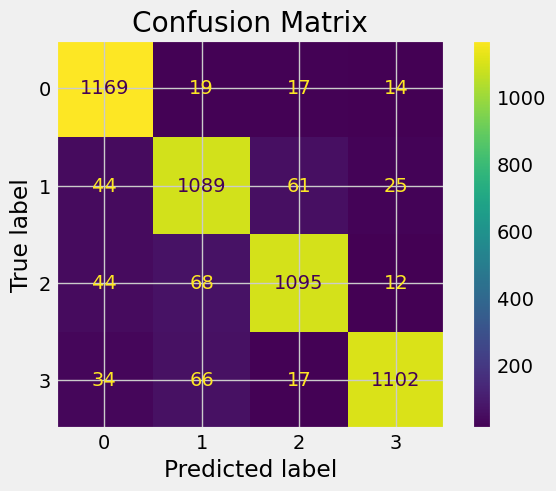

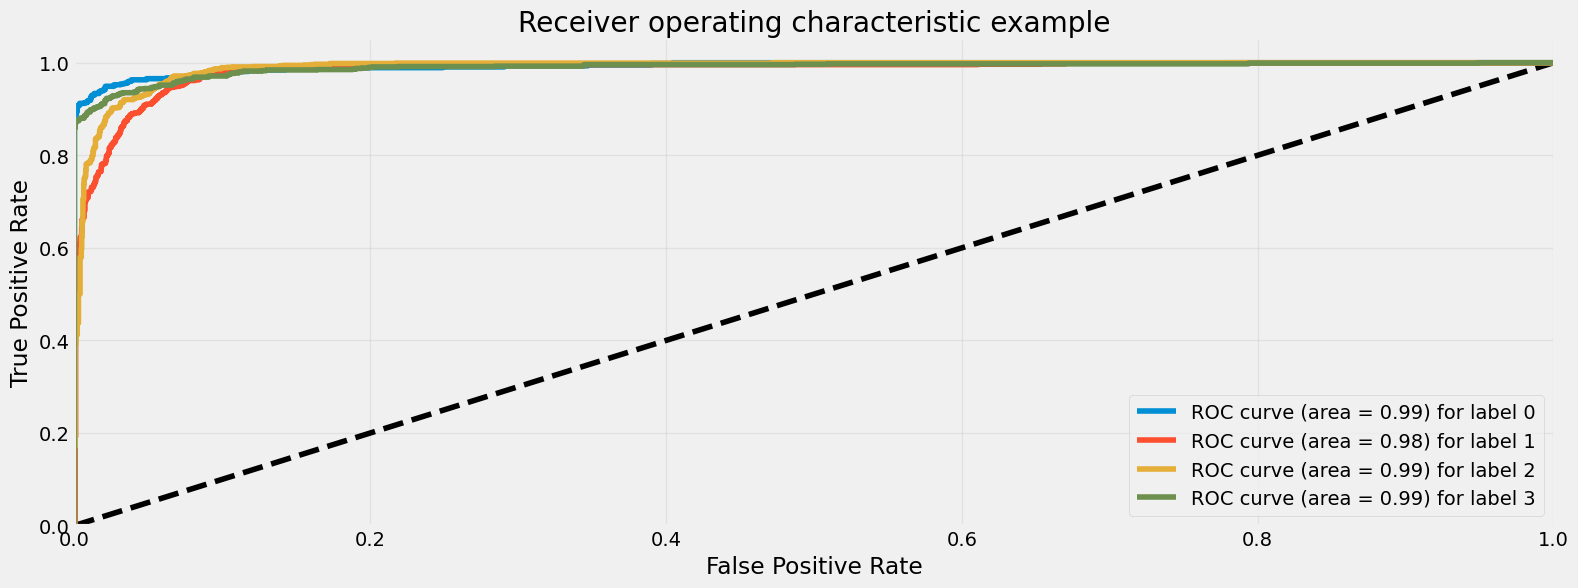

In [54]:
res_lgbm_task2 = train_and_plot(pipeline_task2_lgbm, X_train = X_train_task2, X_test = X_test_task2, y_train = y_train_task2, y_test = y_test_task2)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8d871b9e-4e37-4fce-a22e-8733be6e4afc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>